In [1]:
import pandas as pd
import numpy as np

#from keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing import image
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array



### STEP 1 : Read and preprocess Data 

In this step, we follow these operations : 
1. Read the data from the csv file 
2. Reshape the "pixels" column to (48,48,1). As all the elements in pixels column has length 2304, we can assume that we have a grascale square image with dimensions 48x48 
3. We normalize the pixel values in the image 
4. Split data into train, validation and test sets, using the column "Usage" 


After the initial preprocessing is done, we convert the image arrays into keras ImageDataGenerator() object, for model to process the data easily. We directly converted the validatin and test sets as they are, however, to introduce variance in image orientation, we applied additioal augmentation by adding horizontal flip, rotation change and shift in width and height of the images in the training set.

In [2]:
data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


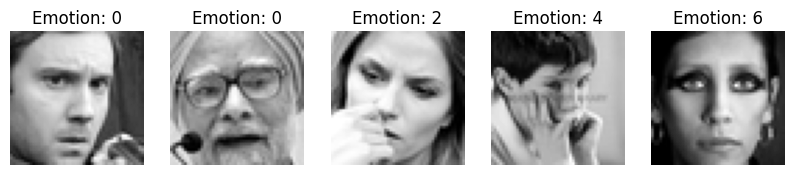

In [3]:
def pixels_to_image(pixel_string):
    '''
    converts the strings into a image, used for plotting purposes 
    '''
    pixels = np.fromstring(pixel_string, sep=' ', dtype=int)
    image_array = pixels.reshape(48, 48)
    image = Image.fromarray(image_array.astype('uint8'))
    return image

def visualize_images(data, num_images=5):
    '''
    plots the images 
    '''
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        pixel_string = data['pixels'][i]
        image = pixels_to_image(pixel_string)
        emotion = data['emotion'][i]

        plt.subplot(1, num_images, i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(f'Emotion: {emotion}')
        plt.axis('off')

    plt.show()

visualize_images(data, num_images=5)

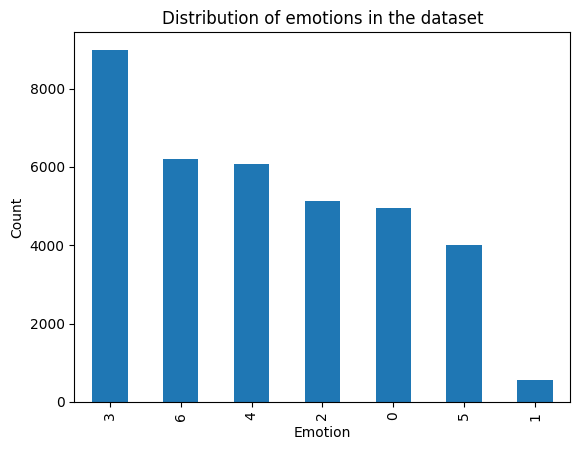

In [4]:
data['emotion'].value_counts().plot(kind='bar')
plt.title('Distribution of emotions in the dataset')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

In [5]:
def preprocess_data():

  '''
  convert str pixels into a 2d image array of shape (48,48)
  split data into train,val and test 

  '''
  data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48, 1))
  data['pixels'] = data['pixels'] / 255.0

  train_data = data[data['Usage'] == 'Training']
  val_data = data[data['Usage'] == 'PublicTest']
  test_data = data[data['Usage'] == 'PrivateTest']

  X_train = np.stack(train_data['pixels'].values)
  y_train = to_categorical(train_data['emotion'].values)

  X_val = np.stack(val_data['pixels'].values)
  y_val = to_categorical(val_data['emotion'].values)

  X_test = np.stack(test_data['pixels'].values)
  y_test = to_categorical(test_data['emotion'].values)

  return X_train,y_train,X_val,y_val,X_test,y_test


def augment_data(X_train,y_train,batch_size=32):
   '''
    augments the training data by applying rotation, width-heigh shift etc. 
    finally converts the train images into a ImageGeneratorDataset instance
   '''
   image_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True
    )

   augmented_data = image_generator.flow(X_train, y_train, batch_size)
   return augmented_data

def convert_to_image(X,y,batch_size=32):
  '''
  converts validation and test sets into ImageDataGenerator objects
  '''
  image_generator = ImageDataGenerator()
  image_data = image_generator.flow(X,y,batch_size)
  return image_data



In [6]:
X_train,y_train,X_val,y_val,X_test,y_test = preprocess_data()

validation = convert_to_image(X_val,y_val)
test = convert_to_image(X_test,y_test)
train = augment_data(X_train,y_train)

### STEP 2 : Construct the Model 

Once the data is preprocessed, the next step is to define the model architecture. To be able to experiment with diffferent model configurations, we implemented create_model() function to accept many parameter such as the # of layers, optimizer, learning rate and loss criterion. By default, to prevent overfitting we incorporate a dropout rate of 0.25, which means 1/4 neurons in the layer will be excluded during each pass between different layers. Moreover, we also kept the fully-connected dense layers constant with 512 neurons, as well as the activation function, since the objective of this assignment is to investigate the convolutional mechanism. At the very end of the architecture, we added an output layer with 7 neurons, as we have 7 classes with a softmax function, to align with the task of multi-class classification. 

In [7]:
def create_model(l32=True, l64=True, l128=True, filter_size = 3 ,l512=False, optimizer='Adam', learning_rate=0.001, loss='categorical_crossentropy'):
    '''
    build the CNN model
    the parameters allow for different architecture configurations. 
    return the compiled model
    '''
    model = Sequential()

    if l32:
        model.add(Conv2D(32, (filter_size, filter_size), activation='relu', input_shape=(48, 48, 1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))

    if l64:
        model.add(Conv2D(64, (filter_size, filter_size), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))

    if l128:
        model.add(Conv2D(128, (filter_size, filter_size), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))

    if l512:
        model.add(Conv2D(512, (filter_size, filter_size), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))

    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy', Precision(), Recall()])

    return model

### STEP 3 : Utility Functions 

To provide more insight into the training process we implemented several utility functions :
- Plot_training() : Plots the training and validation loss/accuracy. It helps us to inspect whether the model is overfitting the training data, as well as the progress each epoch.
- Plot filters() : Visualizes the learnt filters during training in each layer of the CNN. 
- Plot selected activations () : Visualizes the feature activations in the input layer, middle layer and in the later layer.  

In [8]:
def plot_training(history):
    '''
    this fnction plots the train vs validation loss and accuracy
    '''

    plt.figure(figsize=(16, 12))
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()



def plot_filters(layer, layer_name):
    '''
    plots the learned filters by first min-max scaling them 
    '''
    filters, b = layer.get_weights()
    # Min max scaling, otherwise the outputput visualizations appear really odd. 
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    fig, axs = plt.subplots(8, 8, figsize=(8, 8))
    fig.suptitle(layer_name)
    #we iterate 8 times bc we want 8 plots in each row of the figure 
    for i in range(8):
        for j in range(8):
            if i * 8 + j < filters.shape[-1]:
                f = filters[:, :, 0, i * 8 + j]
                axs[i, j].imshow(f, cmap='viridis')
                axs[i, j].axis('off')

    plt.show()



def plot_selected_activations(model, input_image, layer_indices):
    '''
    plots the activations for model and input image at selected layer indices 
    '''
    # get outputs of the layers 
    layer_outputs = [model.layers[idx].output for idx in layer_indices]
    activation_model = Model(inputs=model.inputs, outputs=layer_outputs)
    #get the activation by predicting the instance 
    activations = activation_model.predict(input_image)
    
    # iterate over defined layers 
    #got help from LLMs for neat plotting
    for i, layer_idx in enumerate(layer_indices):
        activation = activations[i]
        num_features = activation.shape[-1] 
        size = activation.shape[1]  # size of the features 
        
        row_size = num_features // 8 # 8 because we want 8 element in the columns
        if num_features % 8 != 0:
            row_size += 1

        fig, ax = plt.subplots(row_size, 8, figsize=(8 * 1.5, row_size * 1.5))
        fig.suptitle(f'Layer {layer_idx + 1}: {model.layers[layer_idx].name}', fontsize=10)

        for feature_idx in range(num_features):
            row = feature_idx // 8
            col = feature_idx % 8
            if row_size == 1:
                ax[col].imshow(activation[0, :, :, feature_idx], cmap='gray')
            else:
                ax[row, col].imshow(activation[0, :, :, feature_idx], cmap='gray')

        for r in range(row_size):
            for c in range(8):
                if r * 8 + c >= num_features:
                    if row_size == 1:
                        ax[c].axis('off')
                    else:
                        ax[r, c].axis('off')
                        
        plt.show()


### STEP 3: Train loop and evaluation 

The model evaluation is performed as follows. We used the validation set to inpsect the performance on unseen data as the model trains. We used accuracy. precision and recall as the main evaluation metrics. Finally we test the trained model on the test set, and compute the performance metrics as well as plot the confusion matrix, to inspect the performance on different classes better. 

During training, we have utilized Early Stopping with patience of 5 epochs, which allows us to terminate the training if there is no progresss recorded for validation loss. By default we chose 50 as number of epochs, due to the limitation in computational resources. 

In [9]:
def test_model(model, test, class_names):
    '''
    evaluate the model using accuracy,precision,recall and confusion matrix 
    '''
    test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test)

    print(f'Test Accuracy: {test_accuracy}')
    print(f'Test Precision: {test_precision}')
    print(f'Test Recall: {test_recall}')

    #predict
    test.reset()
    y_pred = model.predict(test)
    #we need to get the max prob to determine the final class
    y_pred_classes = np.argmax(y_pred, axis=1)

    test.reset()
    y_true = np.array([])
    for i in range(len(test)):
        y_true = np.append(y_true, np.argmax(test[i][1], axis=1))

    # confusion matrix 
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Emotion')
    plt.ylabel('Actual Emotion')
    plt.title('Confusion Matrix')
    plt.show()

def train_model_scheduler_early_callback(modelname, l32=True, l64=True, l128=True, filter_size=3, l512=False, optimizer='Adam', learning_rate=0.001, loss='categorical_crossentropy', class_names=None):
    '''
    create model based on specified parameters and train 
    '''
    model = create_model(l32, l64, l128, filter_size, l512, optimizer, learning_rate, loss)
    print(model.summary())
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    training = model.fit(
        train,
        epochs=50,
        validation_data=validation,
        callbacks=[early_stopping]
    )
    #plot train vs val acccuracy
    plot_training(training) 
    #save 
    model.save(f'{modelname}.keras')
    class_names = [0,1,2,3,4,5,6]
    #evaluate model
    test_model(model, test, class_names)
    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]
    for conv_layer in conv_layers:
        #plot leanred filters
        plot_filters(conv_layer, conv_layer.name)

    input_image = X_test[10].reshape(1, 48, 48, 1) 
    layer_indices = [0, 5,9,11]
    #plot activations for 11th image at input,5,9,11th layers
    plot_selected_activations(model, input_image, layer_indices)
    
    return model

## Test with Model Architecture Complexity 

### Here the aim is to investigate how the model architecture (number of layers specifically) impacts the performance of the model

### Model with 32,64,128 Convolutional Layers

/Users/elifozkan/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_39 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_54 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_13 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_55 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,295 (4.38 MB)

 Trainable params: 1,146,823 (4.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

None
Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 34s 37ms/step - accuracy: 0.2407 - loss: 2.3464 - precision_13: 0.2768 - recall_13: 0.1131 - val_accuracy: 0.3937 - val_loss: 1.5511 - val_precision_13: 0.6848 - val_recall_13: 0.1828
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.3603 - loss: 1.6468 - precision_13: 0.5728 - recall_13: 0.1429 - val_accuracy: 0.3973 - val_loss: 1.5680 - val_precision_13: 0.6267 - val_recall_13: 0.1441
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.4111 - loss: 1.5154 - precision_13: 0.6595 - recall_13: 0.1886 - val_accuracy: 0.3667 - val_loss: 1.7877 - val_precision_13: 0.4743 - val_recall_13: 0.2884
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.4364 - loss: 1.4608 - precision_13: 0.6775 - recall_13: 0.2150 - val_accuracy: 0.4904 - val_loss: 1.3442 - val_precision_13: 0.6698 - val_recall_13: 0.3182
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 32s 36ms/step - accuracy: 0.4552 - loss: 1.4279 - precision

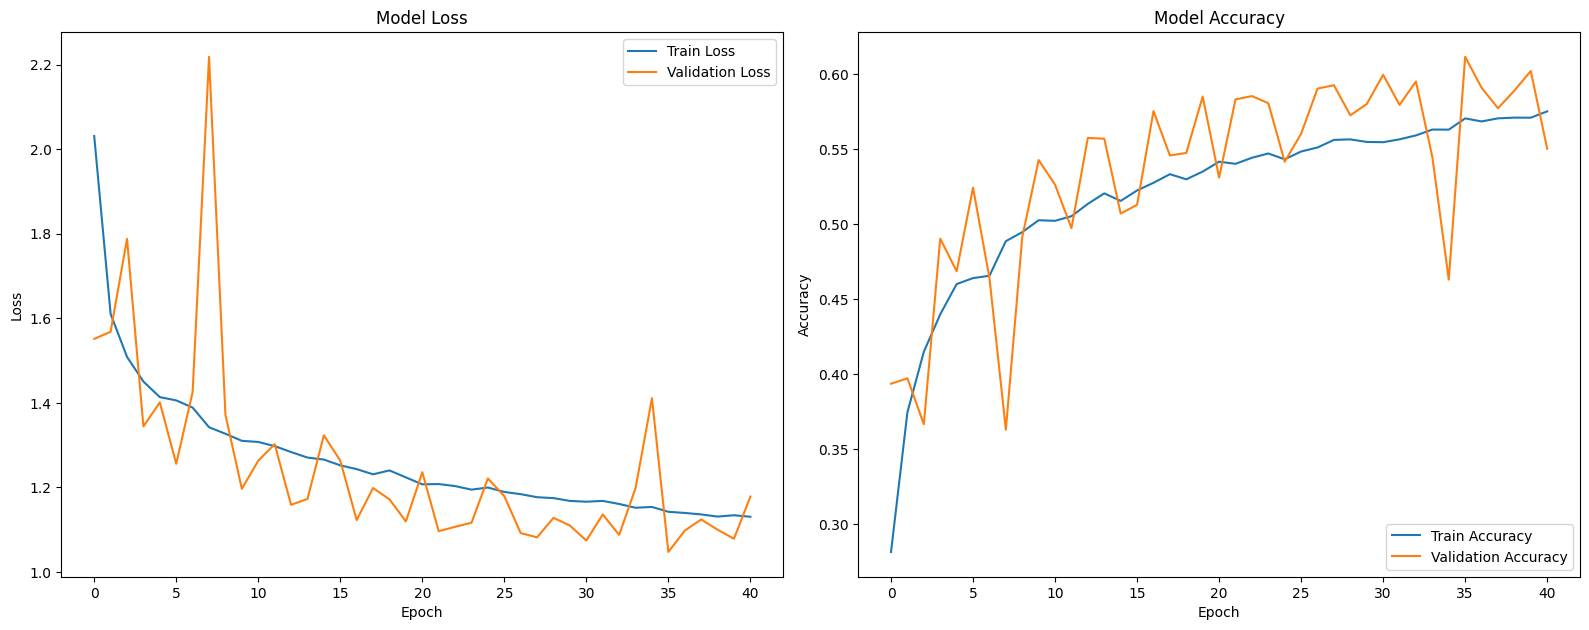

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6147 - loss: 1.0412 - precision_13: 0.7581 - recall_13: 0.4532
Test Accuracy: 0.6166062951087952
Test Precision: 0.7596722841262817
Test Recall: 0.46503204107284546
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


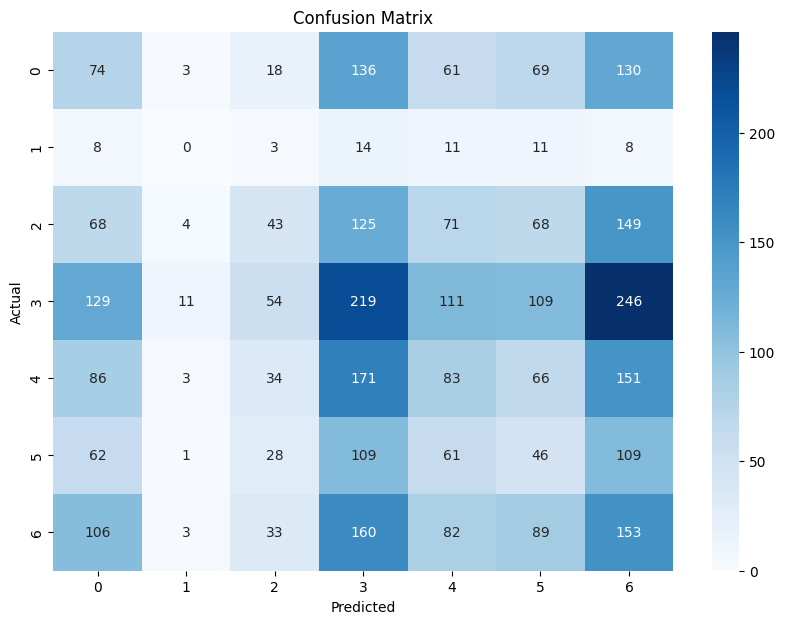

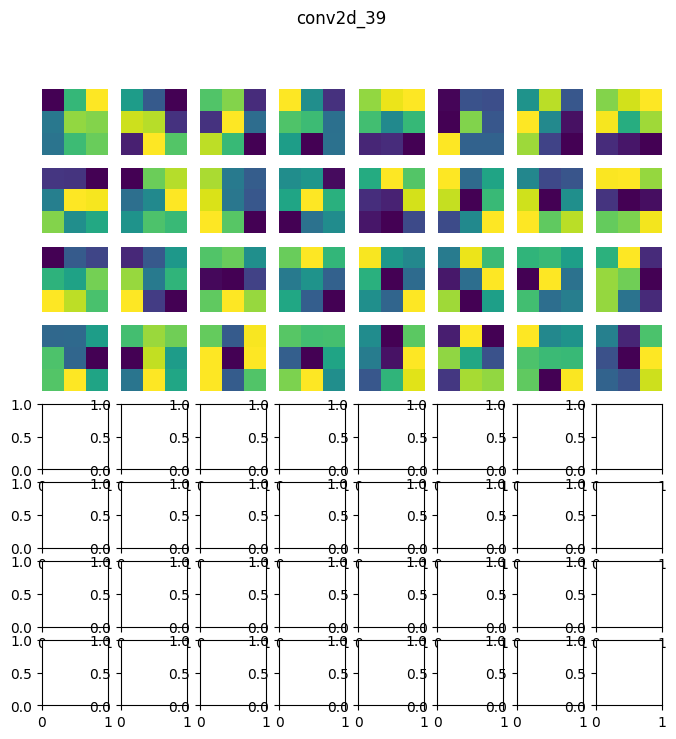

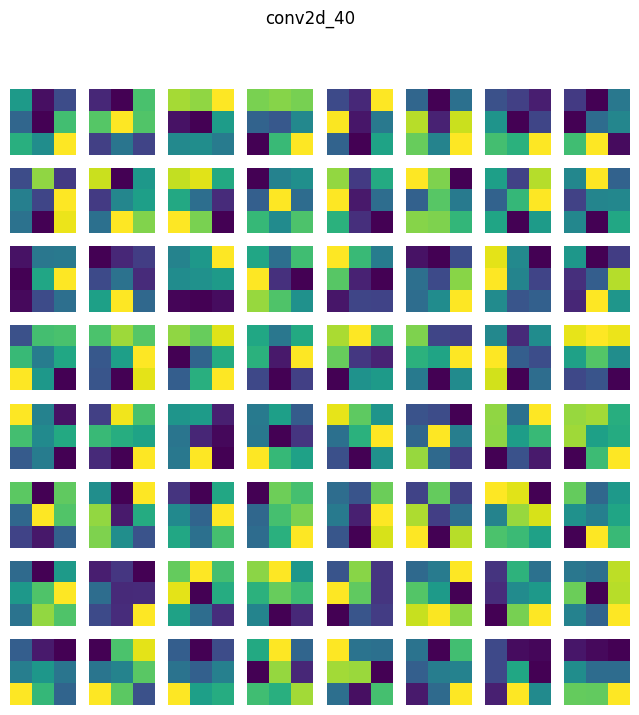

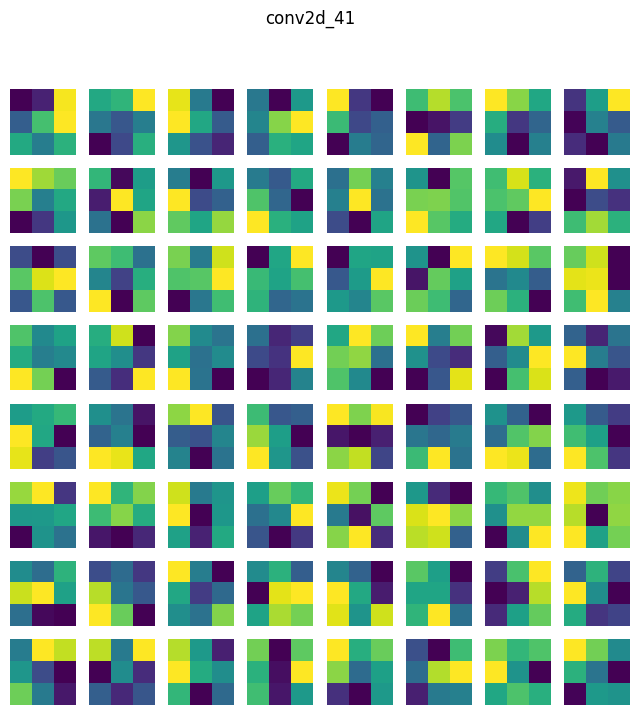

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


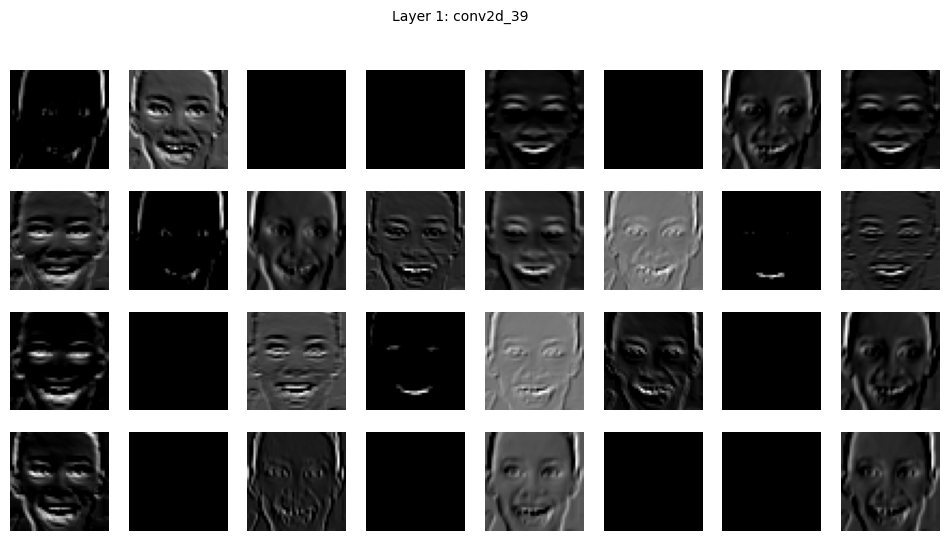

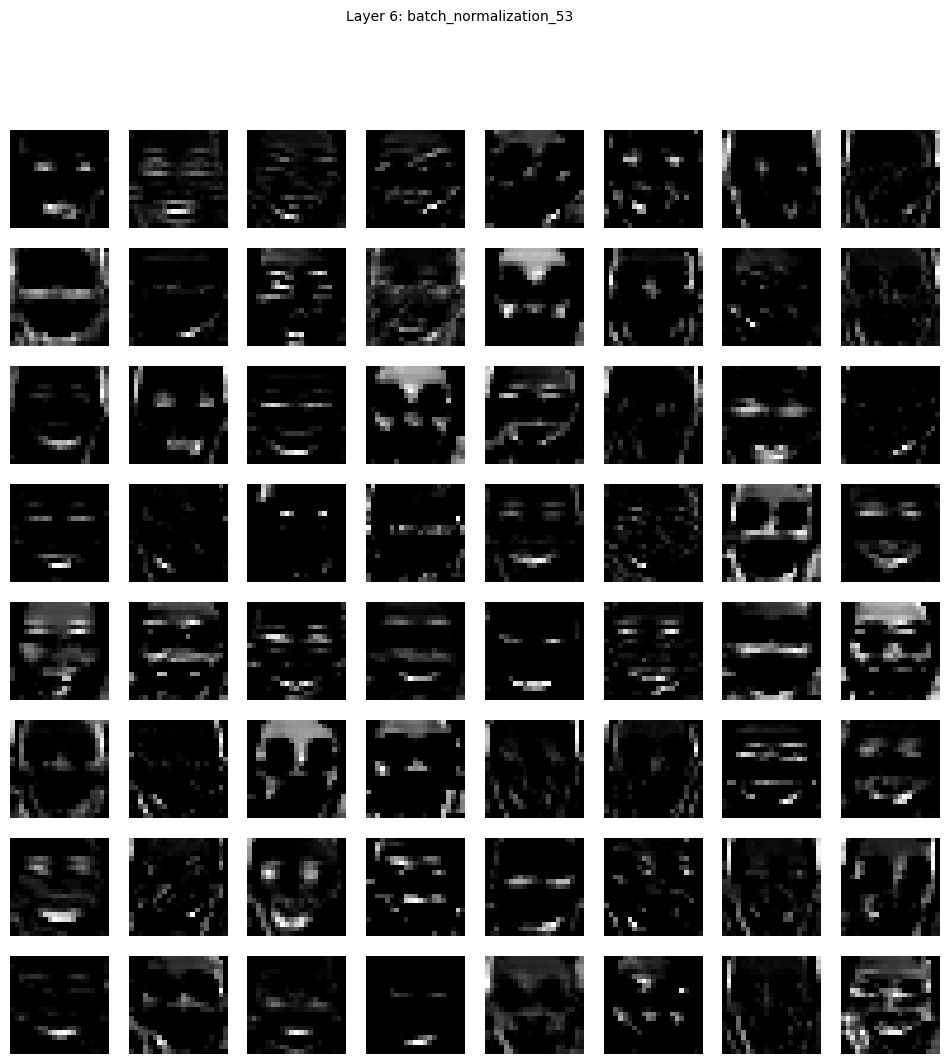

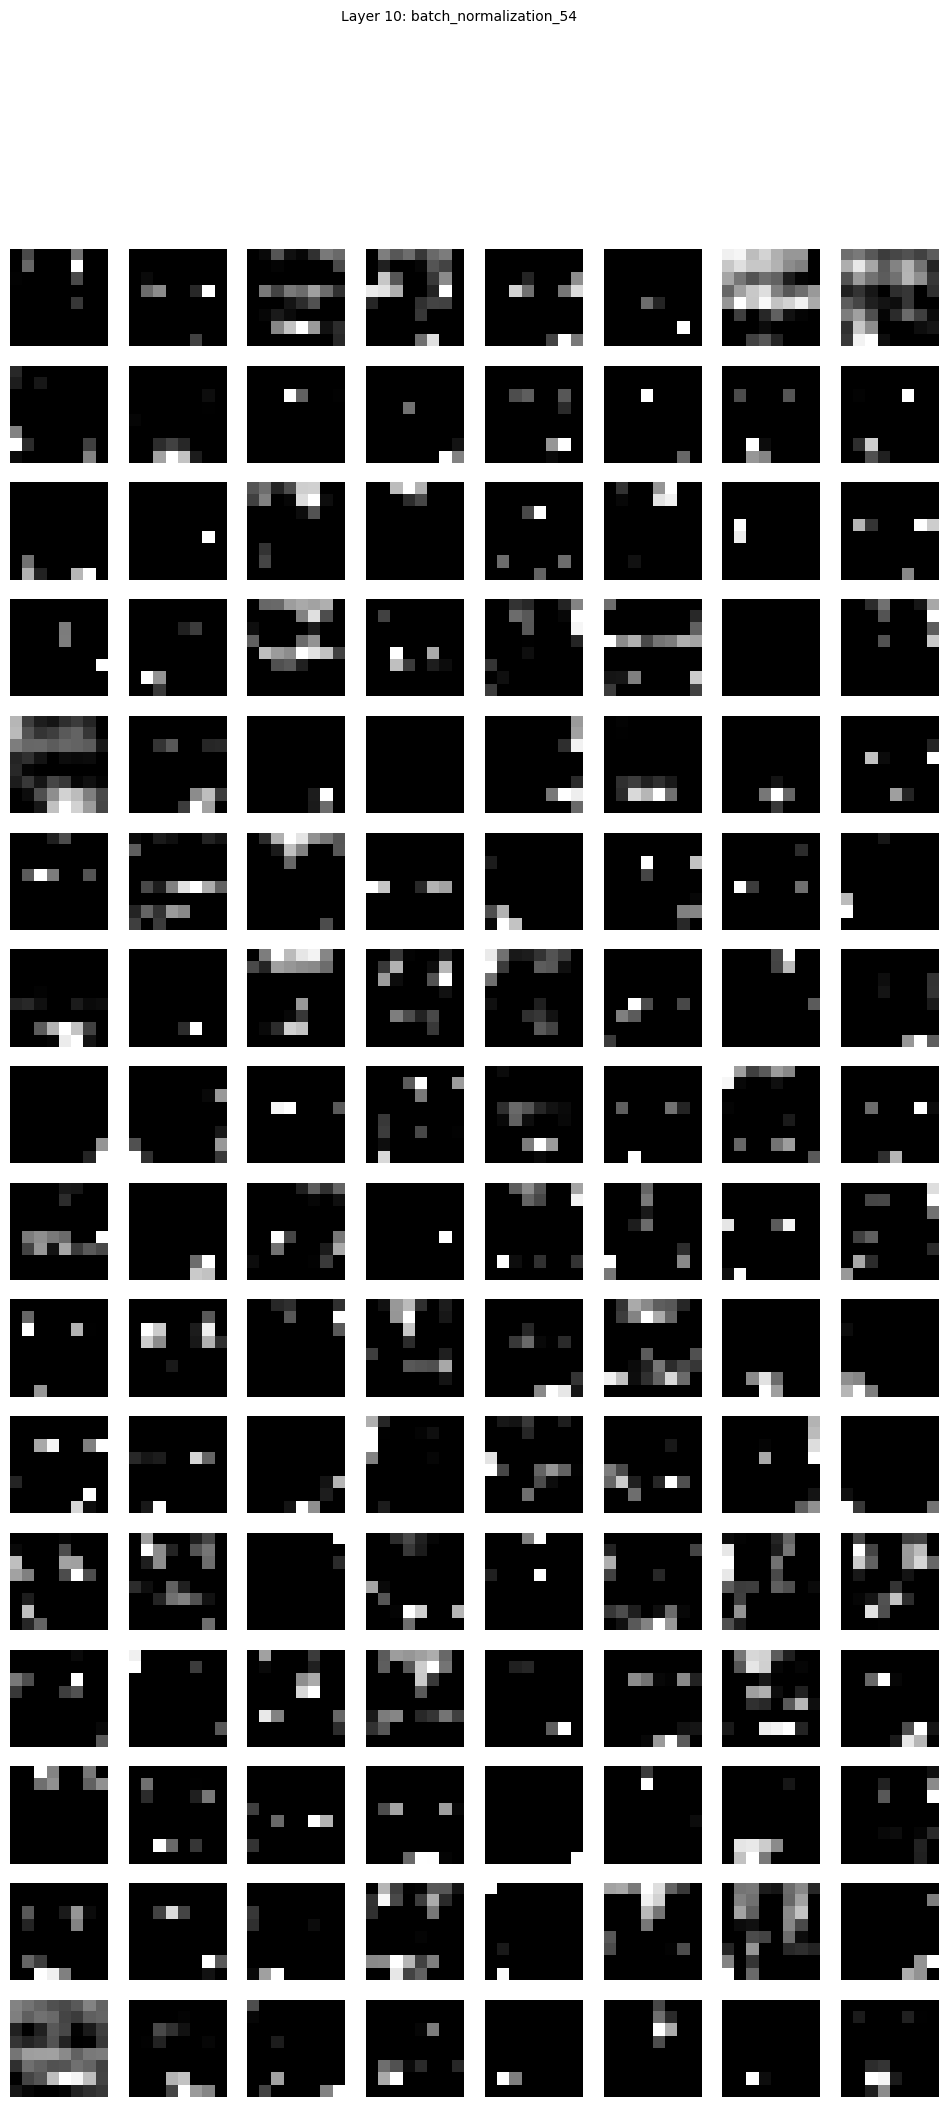

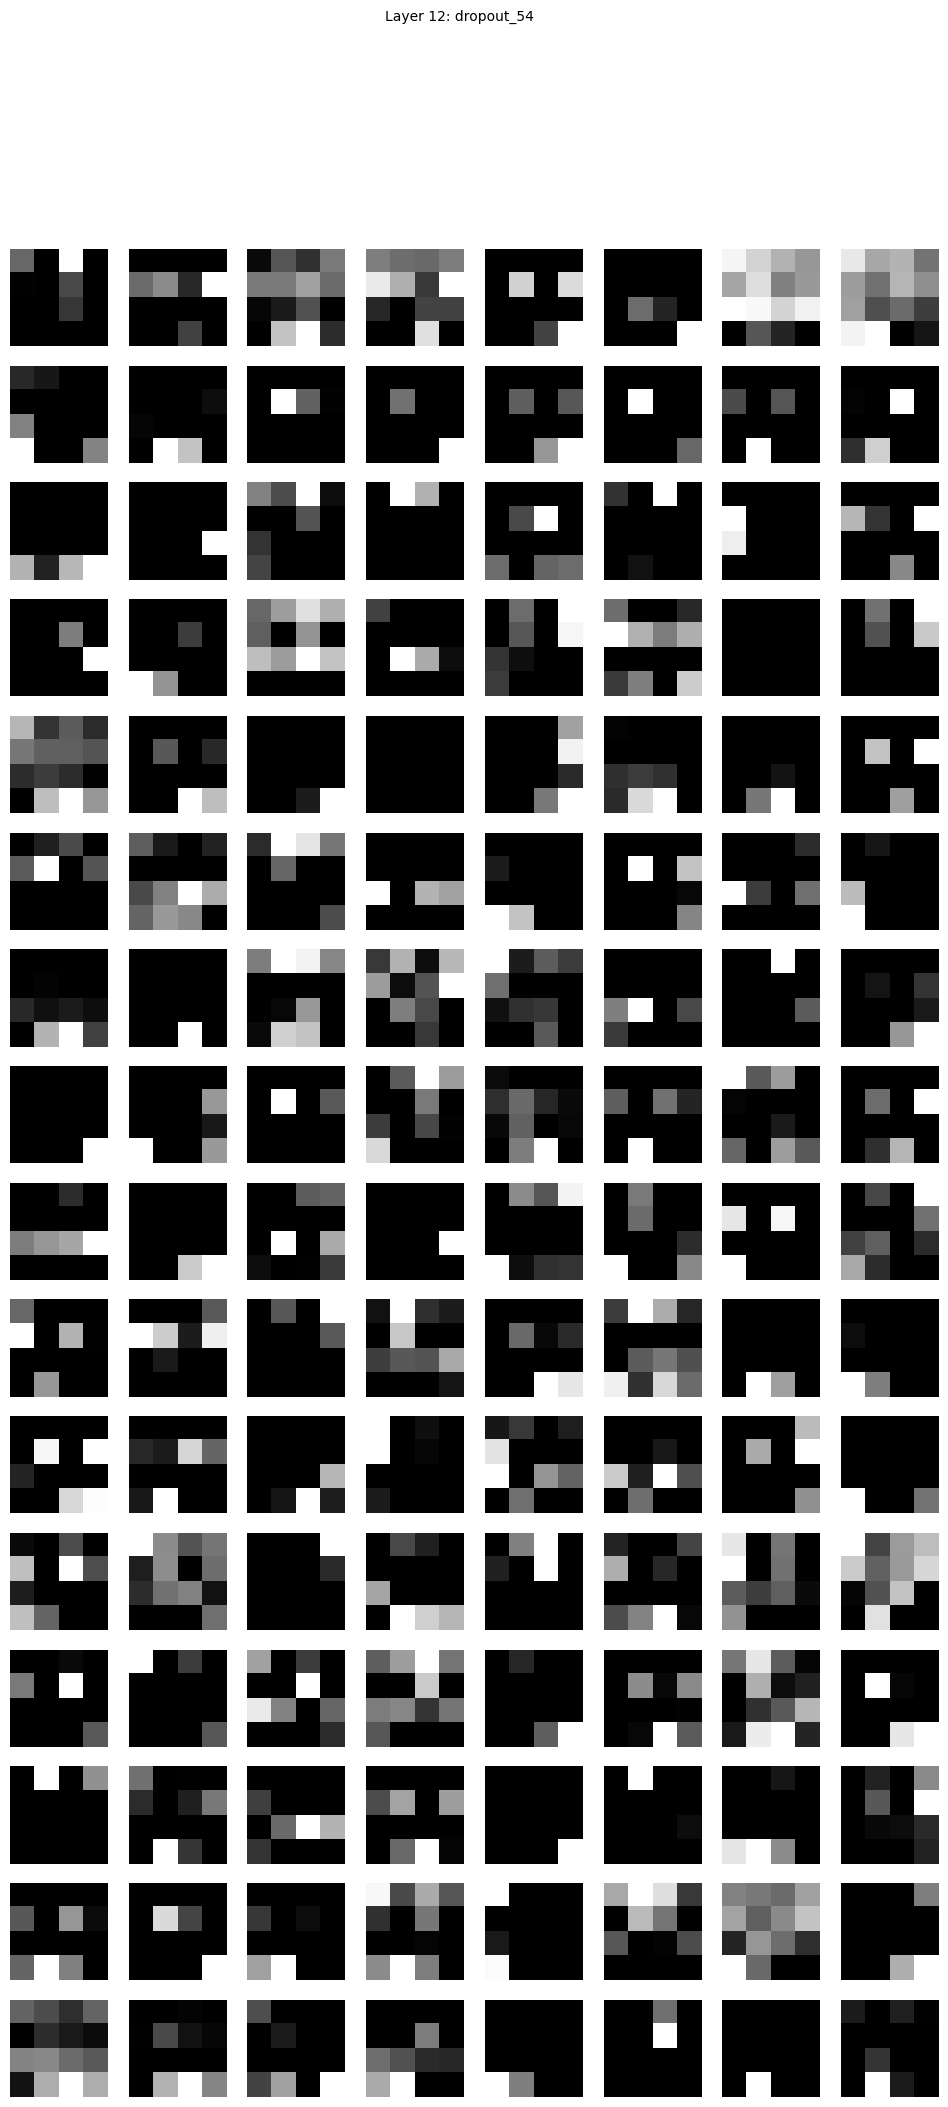

In [62]:
model = train_model_scheduler_early_callback("model128")

### Model with 32,64,128 and 512 convolutional Layers 

/Users/elifozkan/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_56          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_56 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_57          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_57 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_58          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_58 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_45 (Conv2D)              │ (None, 2, 2, 512)      │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_59          │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_45 (MaxPooling2D) │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_59 (Dropout)            │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_60          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_60 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 954,247 (3.64 MB)

 Trainable params: 951,751 (3.63 MB)

 Non-trainable params: 2,496 (9.75 KB)

None
Epoch 1/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.2187 - loss: 2.4175 - precision_14: 0.2307 - recall_14: 0.0855 - val_accuracy: 0.3500 - val_loss: 1.6511 - val_precision_14: 0.5699 - val_recall_14: 0.1045
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 39s 43ms/step - accuracy: 0.3520 - loss: 1.6760 - precision_14: 0.5512 - recall_14: 0.1317 - val_accuracy: 0.3943 - val_loss: 1.6506 - val_precision_14: 0.5359 - val_recall_14: 0.2786
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.4119 - loss: 1.5189 - precision_14: 0.6526 - recall_14: 0.1935 - val_accuracy: 0.4773 - val_loss: 1.3938 - val_precision_14: 0.6622 - val_recall_14: 0.3146
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 38s 42ms/step - accuracy: 0.4471 - loss: 1.4440 - precision_14: 0.6762 - recall_14: 0.2270 - val_accuracy: 0.4391 - val_loss: 1.4547 - val_precision_14: 0.6642 - val_recall_14: 0.2293
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.4610 - loss: 1.4113 - precision

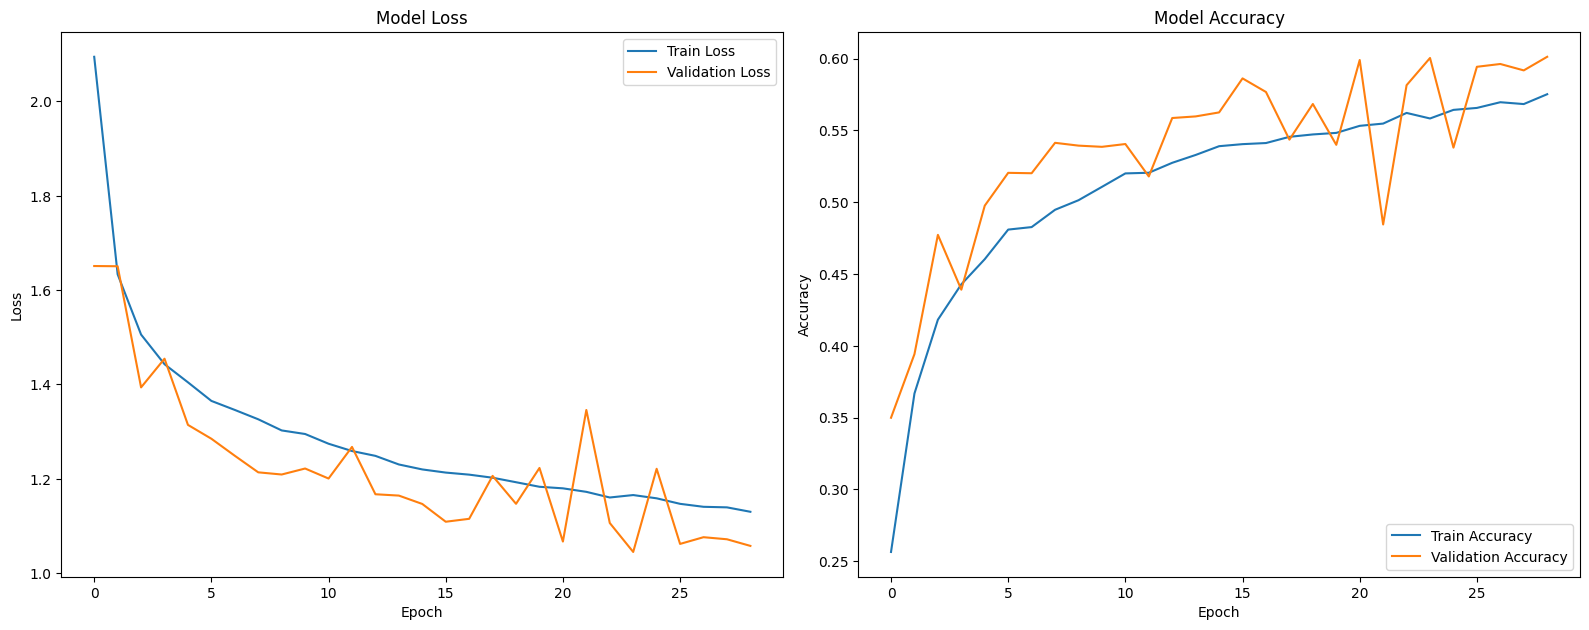

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6255 - loss: 1.0048 - precision_14: 0.8083 - recall_14: 0.4521
Test Accuracy: 0.6115909814834595
Test Precision: 0.7841300964355469
Test Recall: 0.44329896569252014
113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


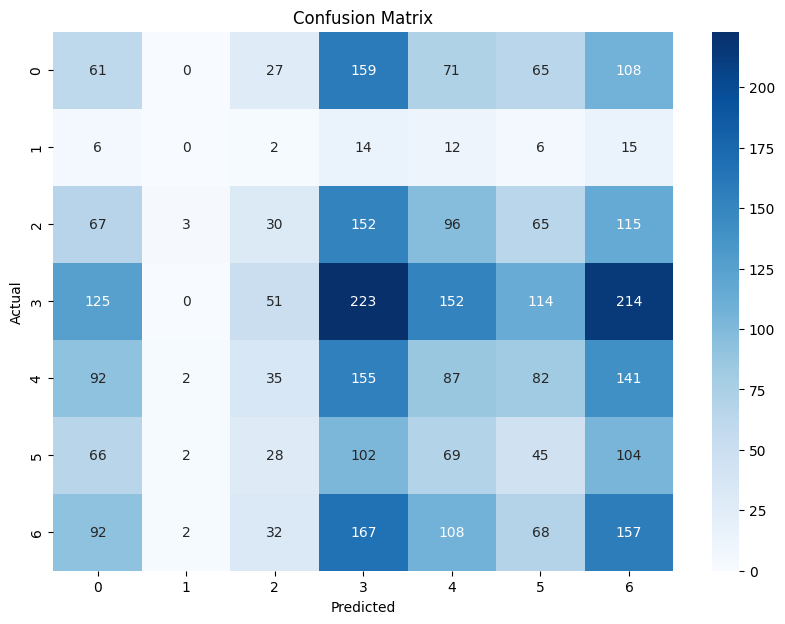

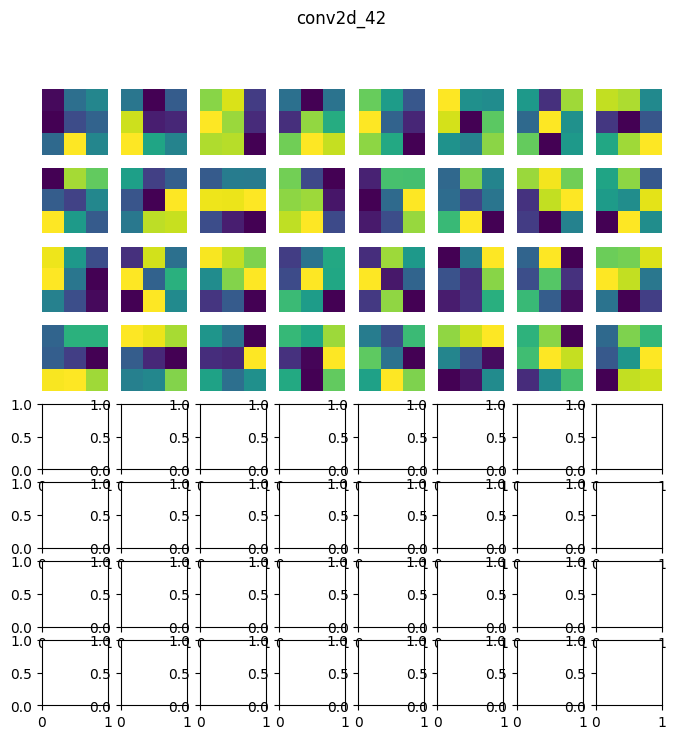

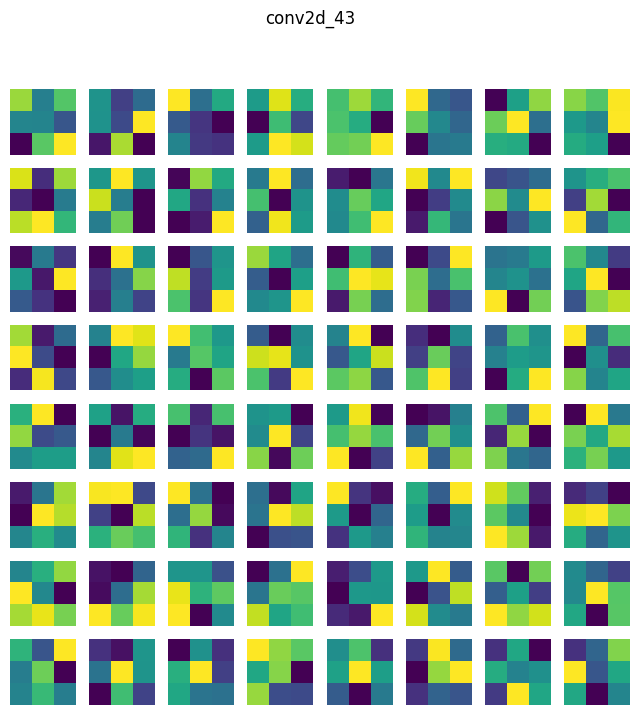

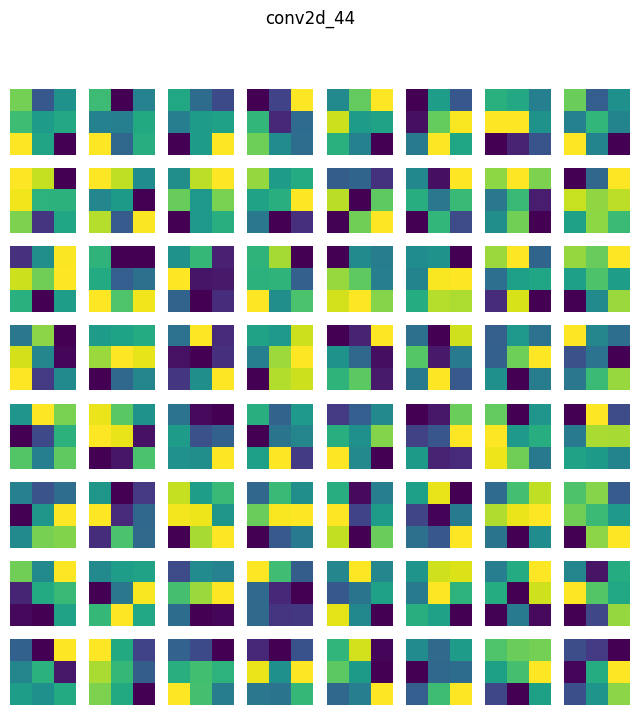

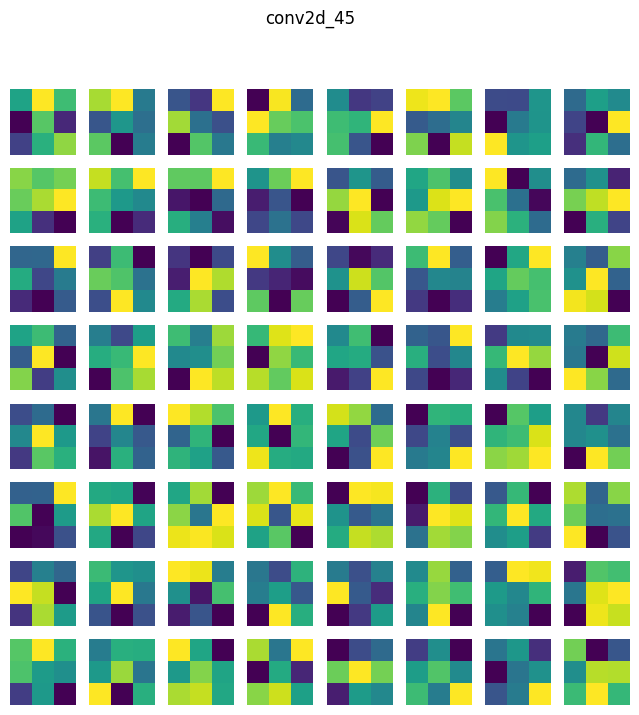

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


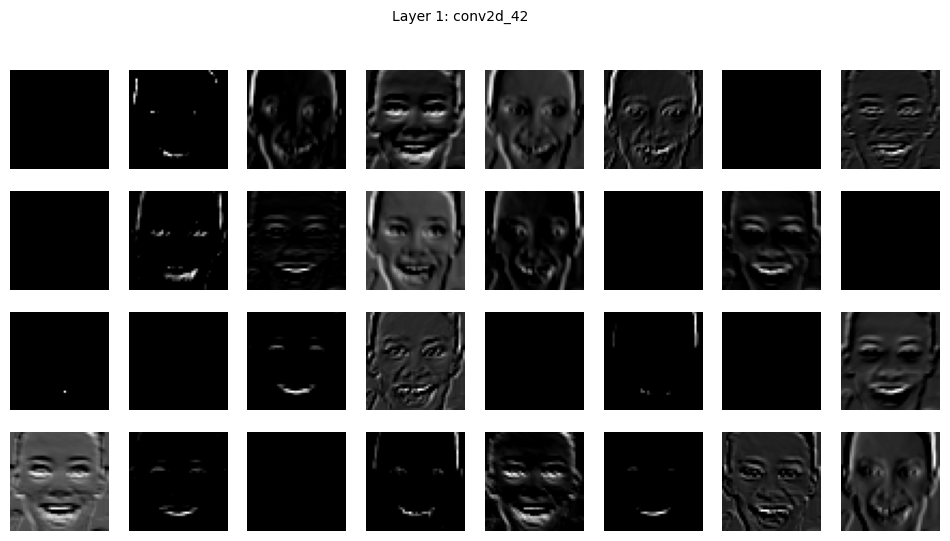

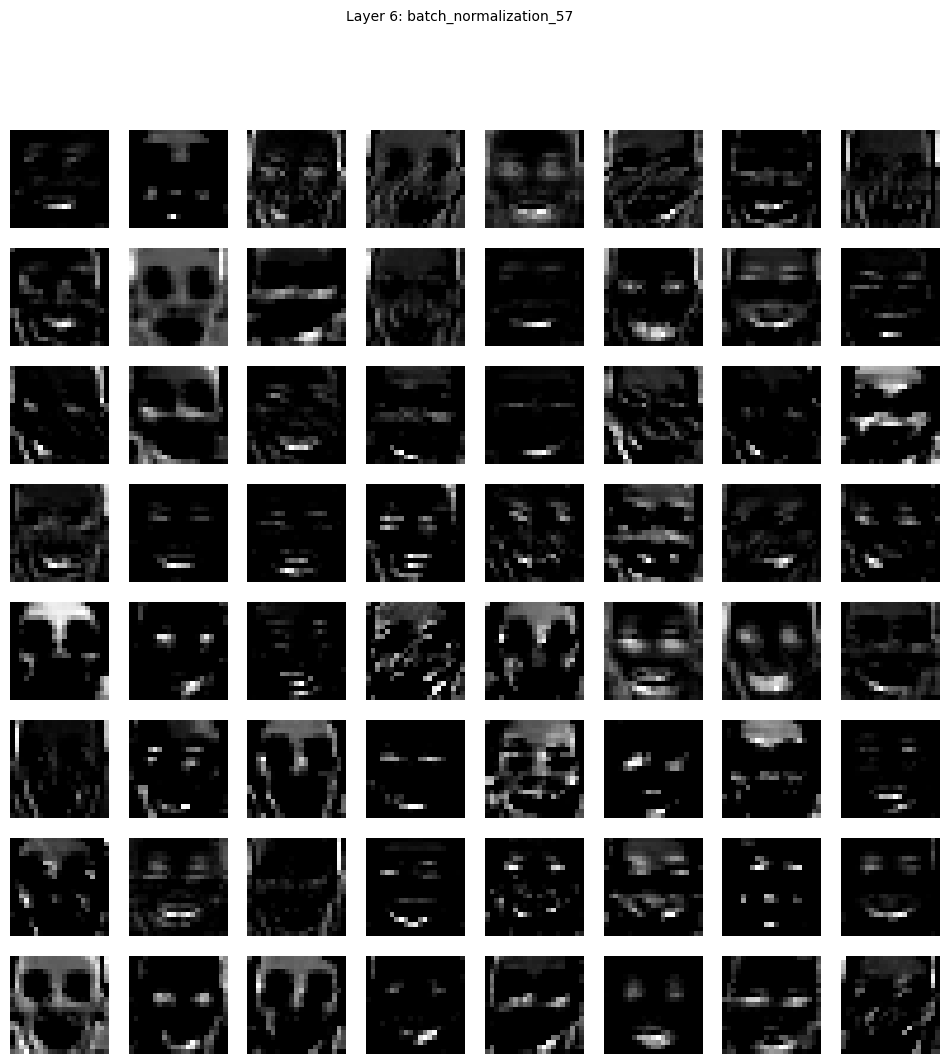

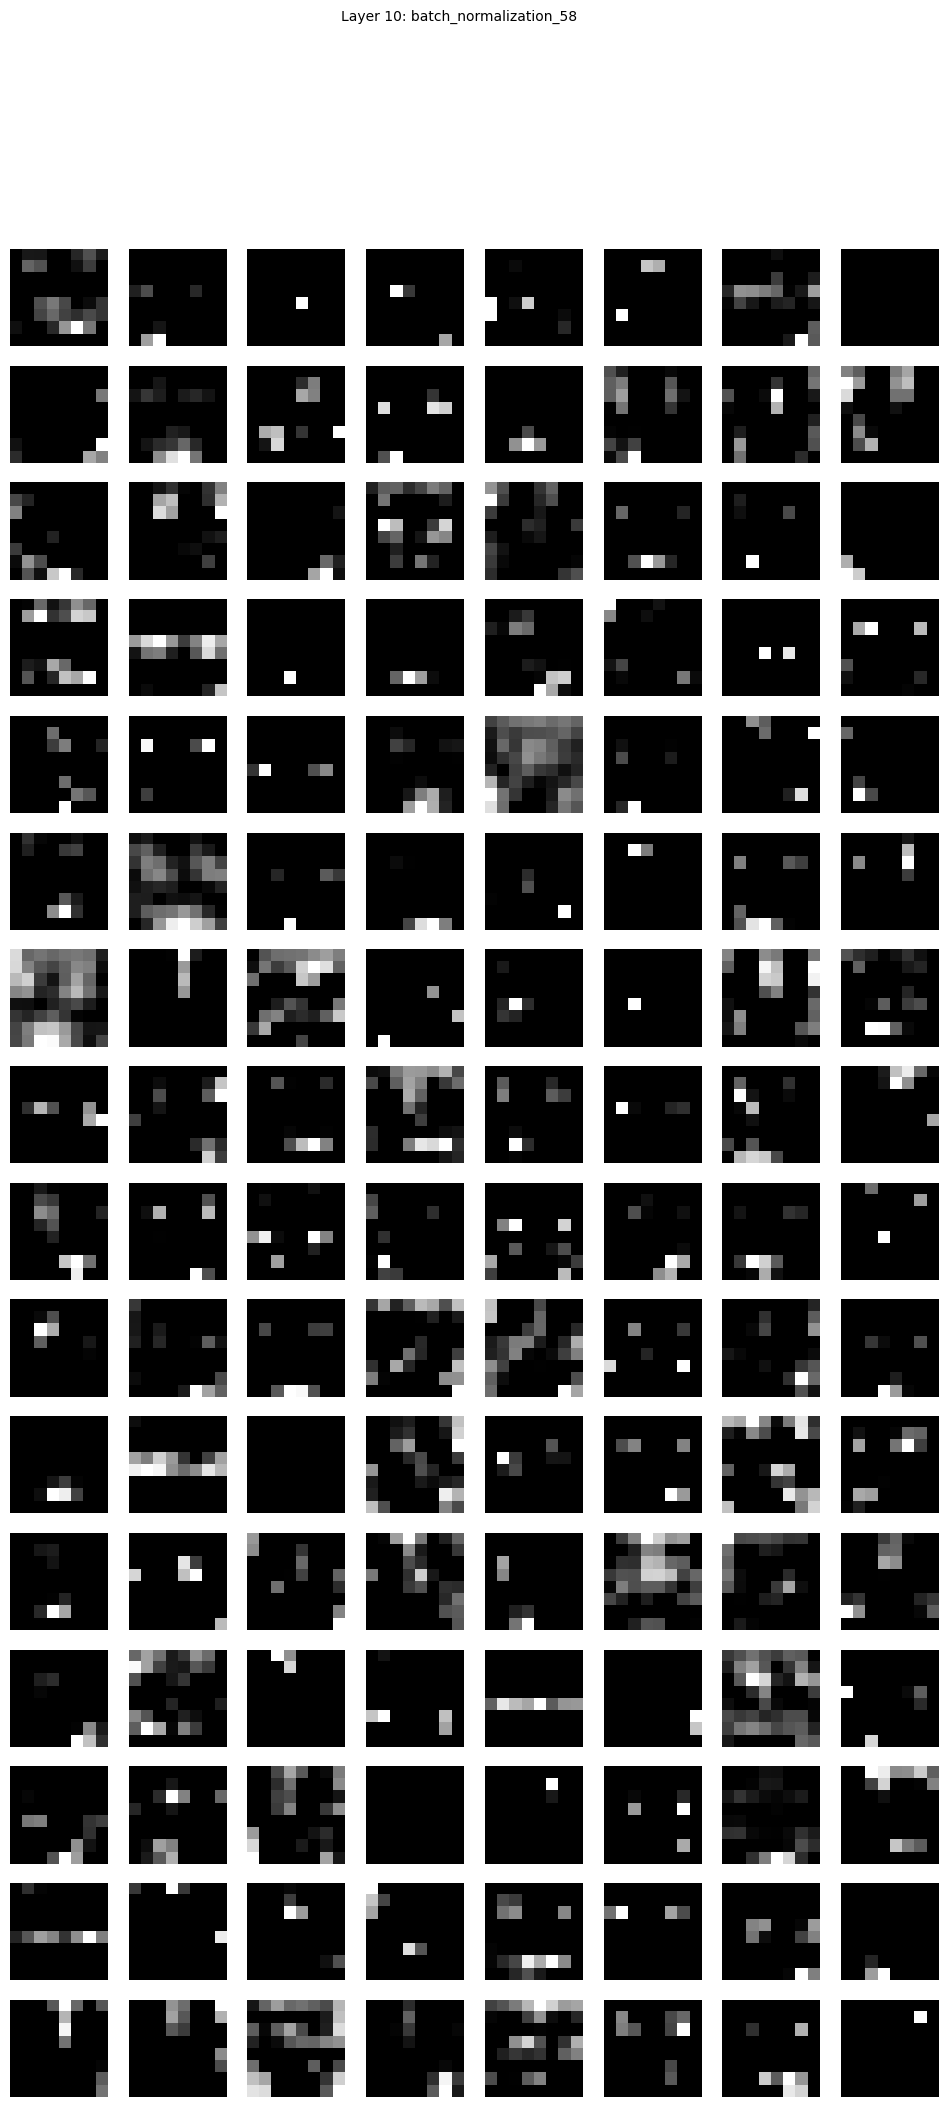

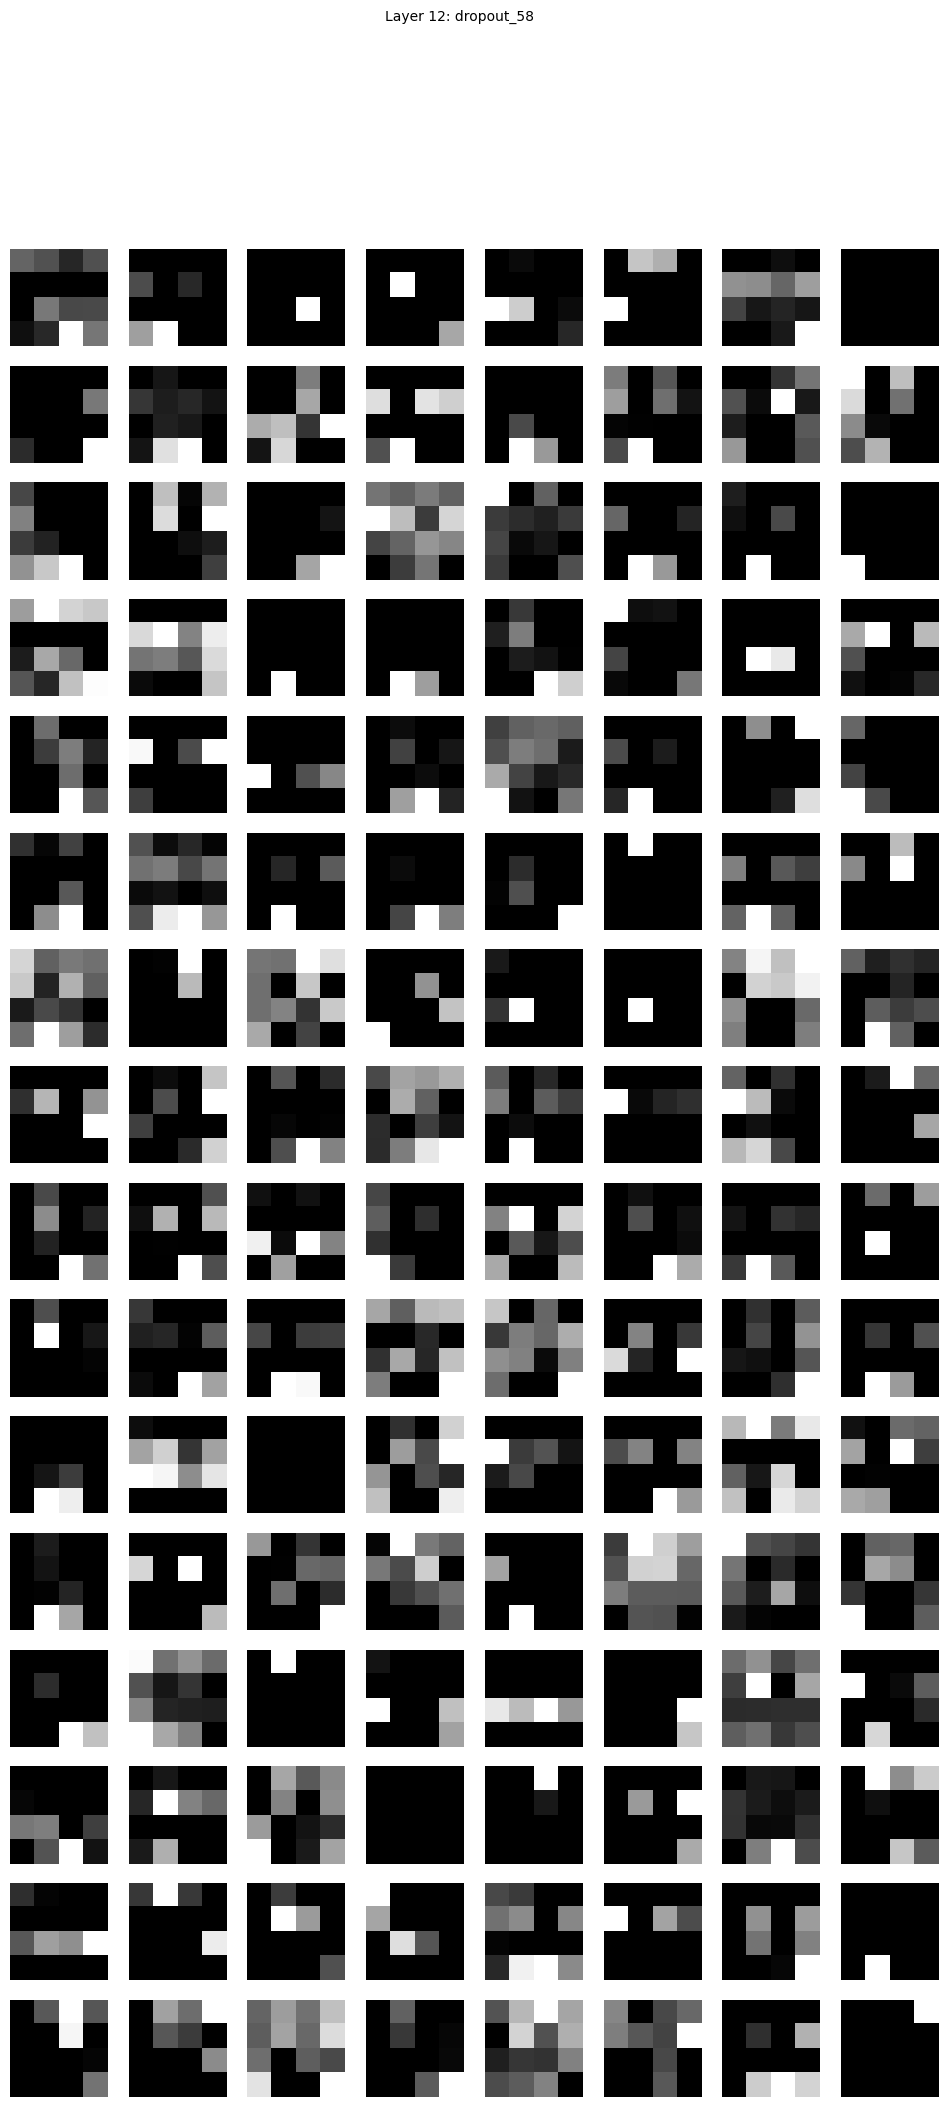

In [63]:
model512 = train_model_scheduler_early_callback("model512",l512=True)

### Model with Different Filter Sizes 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 44, 44, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 44, 44, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 22, 22, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 18, 18, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 18, 18, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 526,215 (2.01 MB)

 Trainable params: 524,743 (2.00 MB)

 Non-trainable params: 1,472 (5.75 KB)

None
Epoch 1/50
  3/898 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - accuracy: 0.1823 - loss: 3.3267 - precision_1: 0.1567 - recall_1: 0.0972

/Users/elifozkan/miniconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 46s 50ms/step - accuracy: 0.2105 - loss: 2.3796 - precision_1: 0.2301 - recall_1: 0.0824 - val_accuracy: 0.2795 - val_loss: 1.7682 - val_precision_1: 0.4961 - val_recall_1: 0.0178
Epoch 2/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 45s 50ms/step - accuracy: 0.3289 - loss: 1.7397 - precision_1: 0.5248 - recall_1: 0.1041 - val_accuracy: 0.3672 - val_loss: 1.6233 - val_precision_1: 0.6070 - val_recall_1: 0.1067
Epoch 3/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 44s 49ms/step - accuracy: 0.3735 - loss: 1.6117 - precision_1: 0.6240 - recall_1: 0.1437 - val_accuracy: 0.4313 - val_loss: 1.4633 - val_precision_1: 0.7108 - val_recall_1: 0.1959
Epoch 4/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.4007 - loss: 1.5444 - precision_1: 0.6551 - recall_1: 0.1750 - val_accuracy: 0.4363 - val_loss: 1.4841 - val_precision_1: 0.7087 - val_recall_1: 0.1973
Epoch 5/50
898/898 ━━━━━━━━━━━━━━━━━━━━ 43s 48ms/step - accuracy: 0.4261 - loss: 1.4919 - precision_1: 0.6670 - recall_1: 0.2010 - 

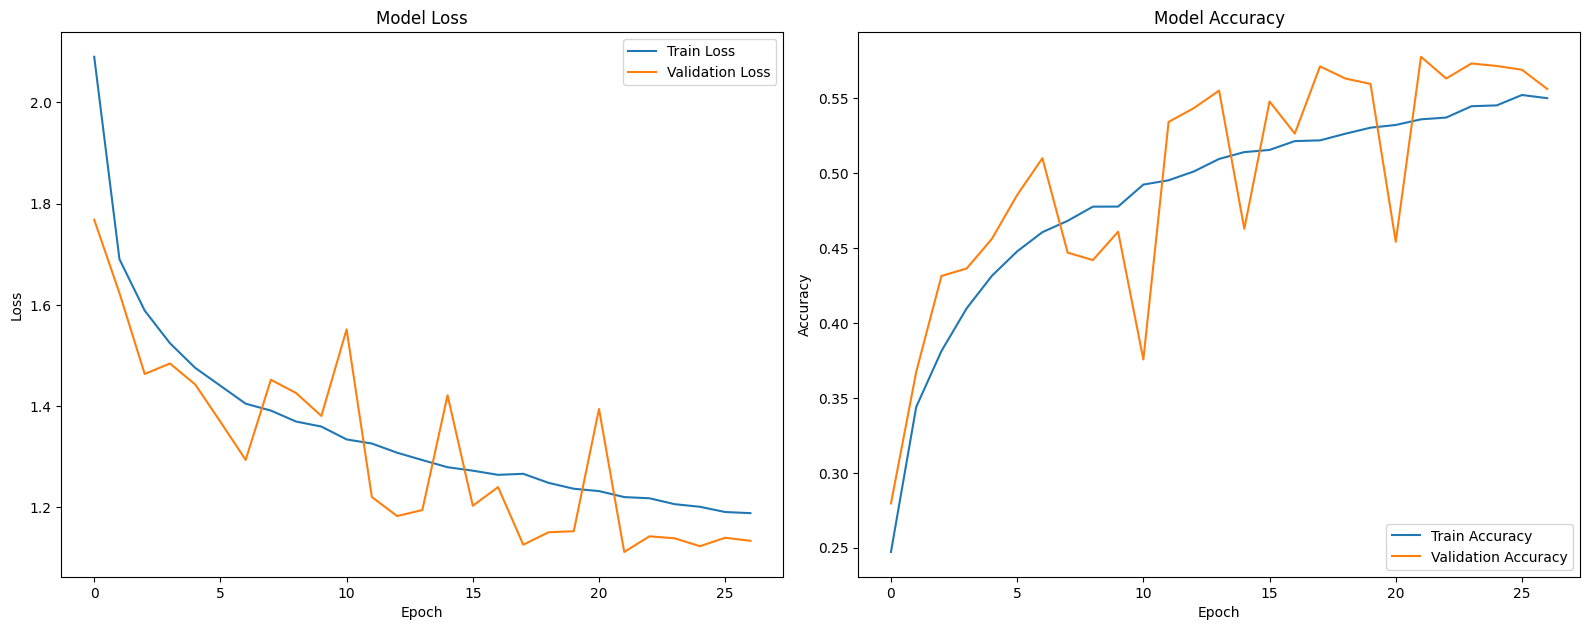

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5678 - loss: 1.0953 - precision_1: 0.7469 - recall_1: 0.4097
Test Accuracy: 0.5784341096878052
Test Precision: 0.7573010921478271
Test Recall: 0.419058233499527
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


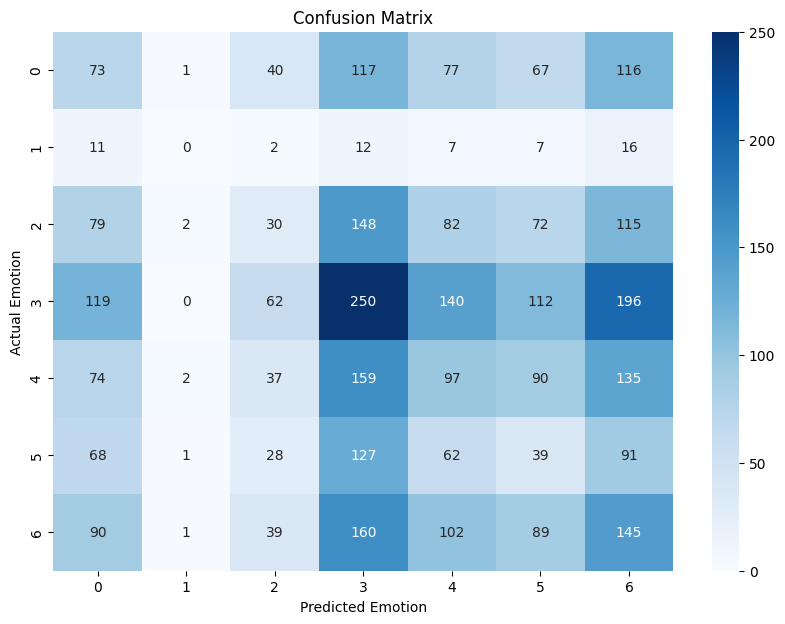

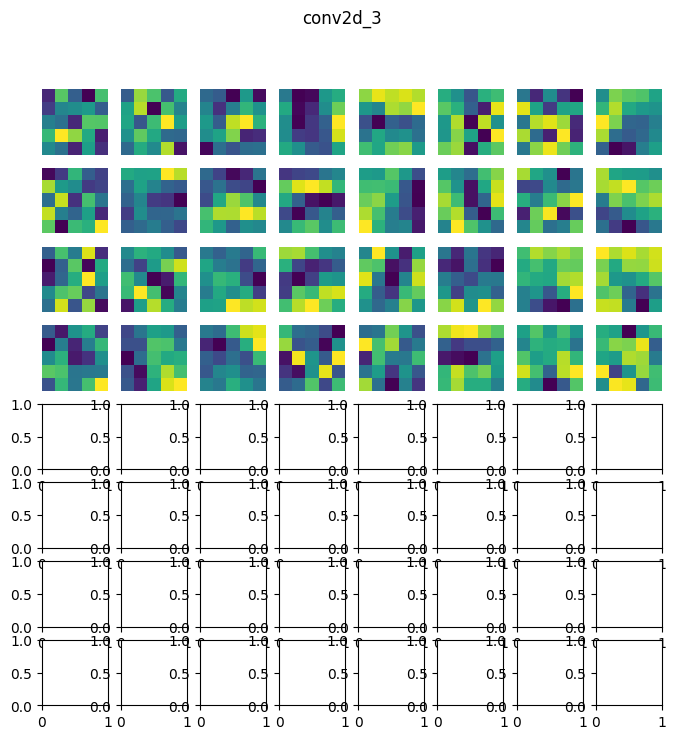

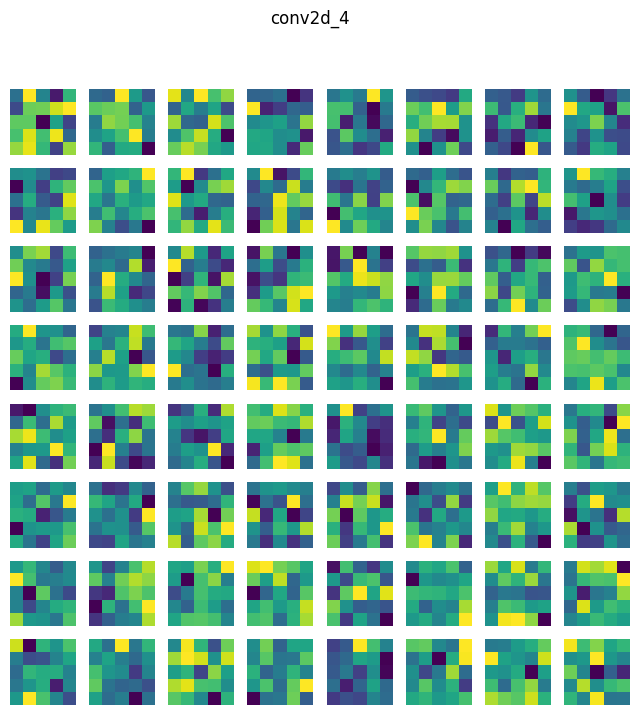

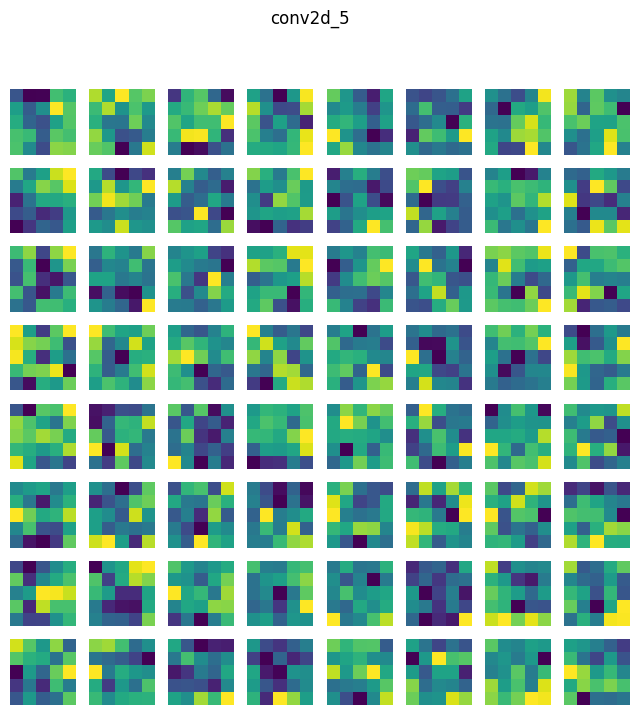

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


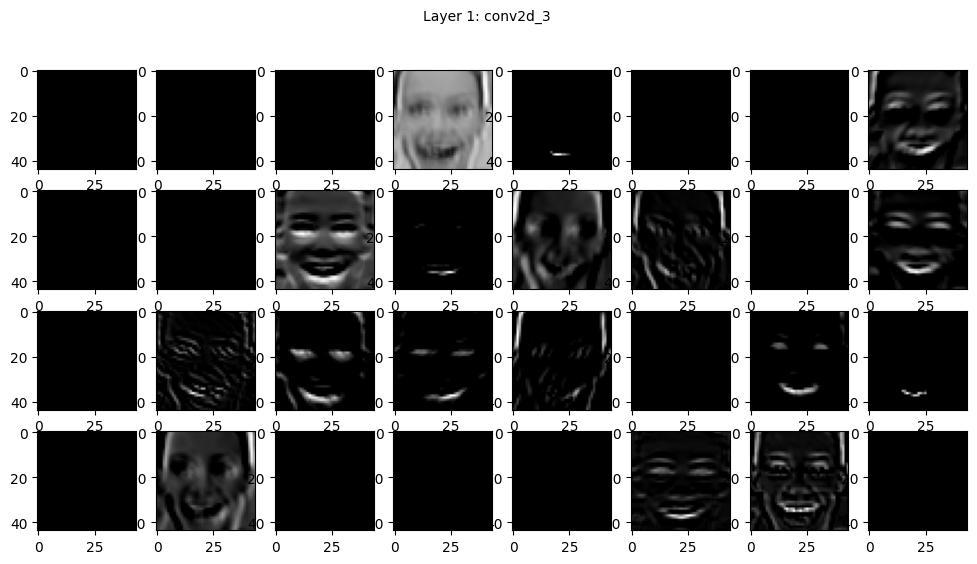

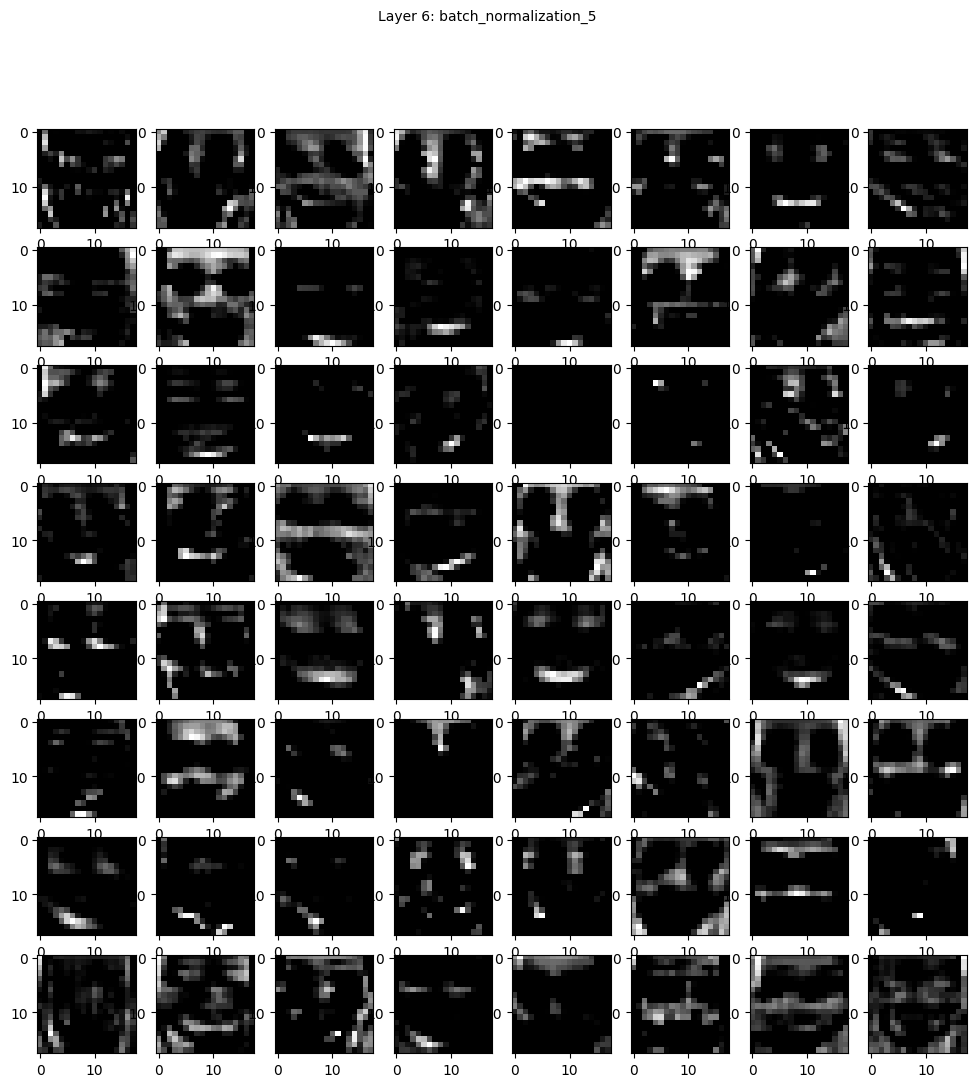

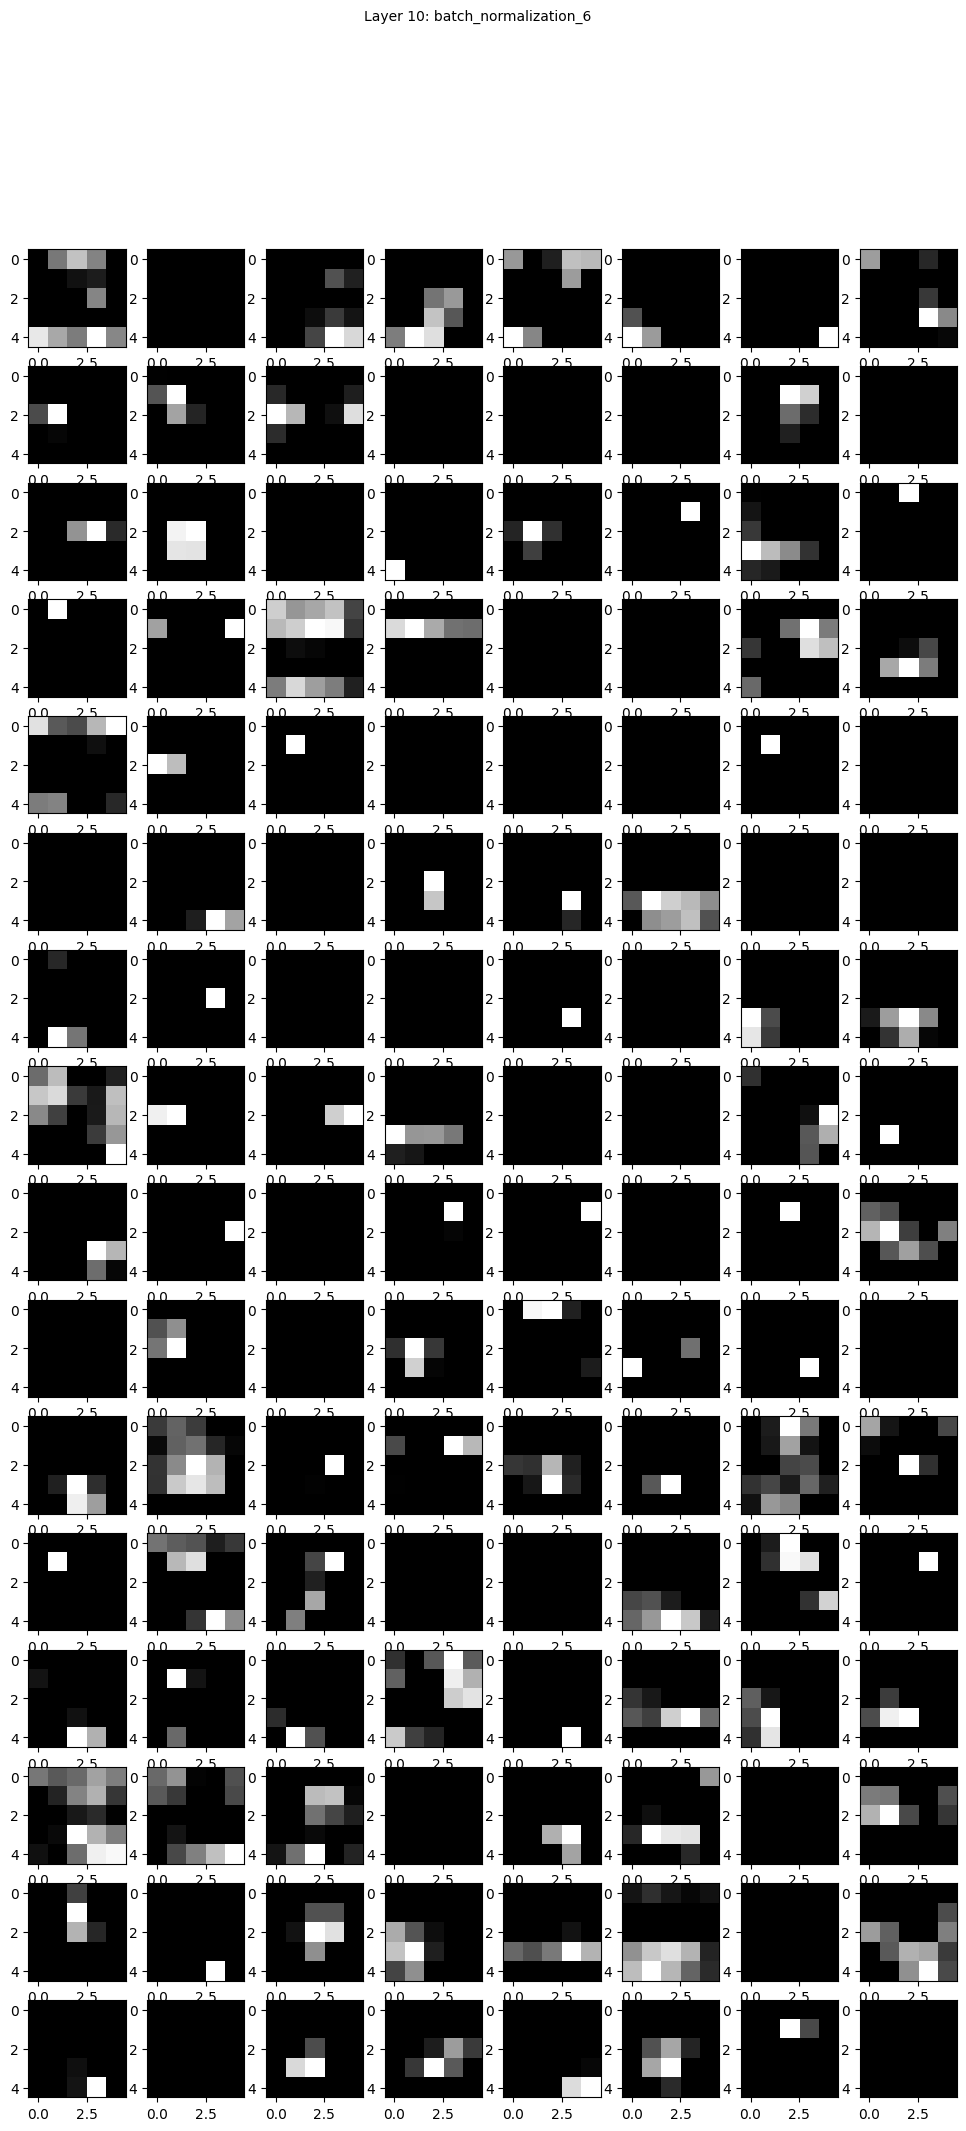

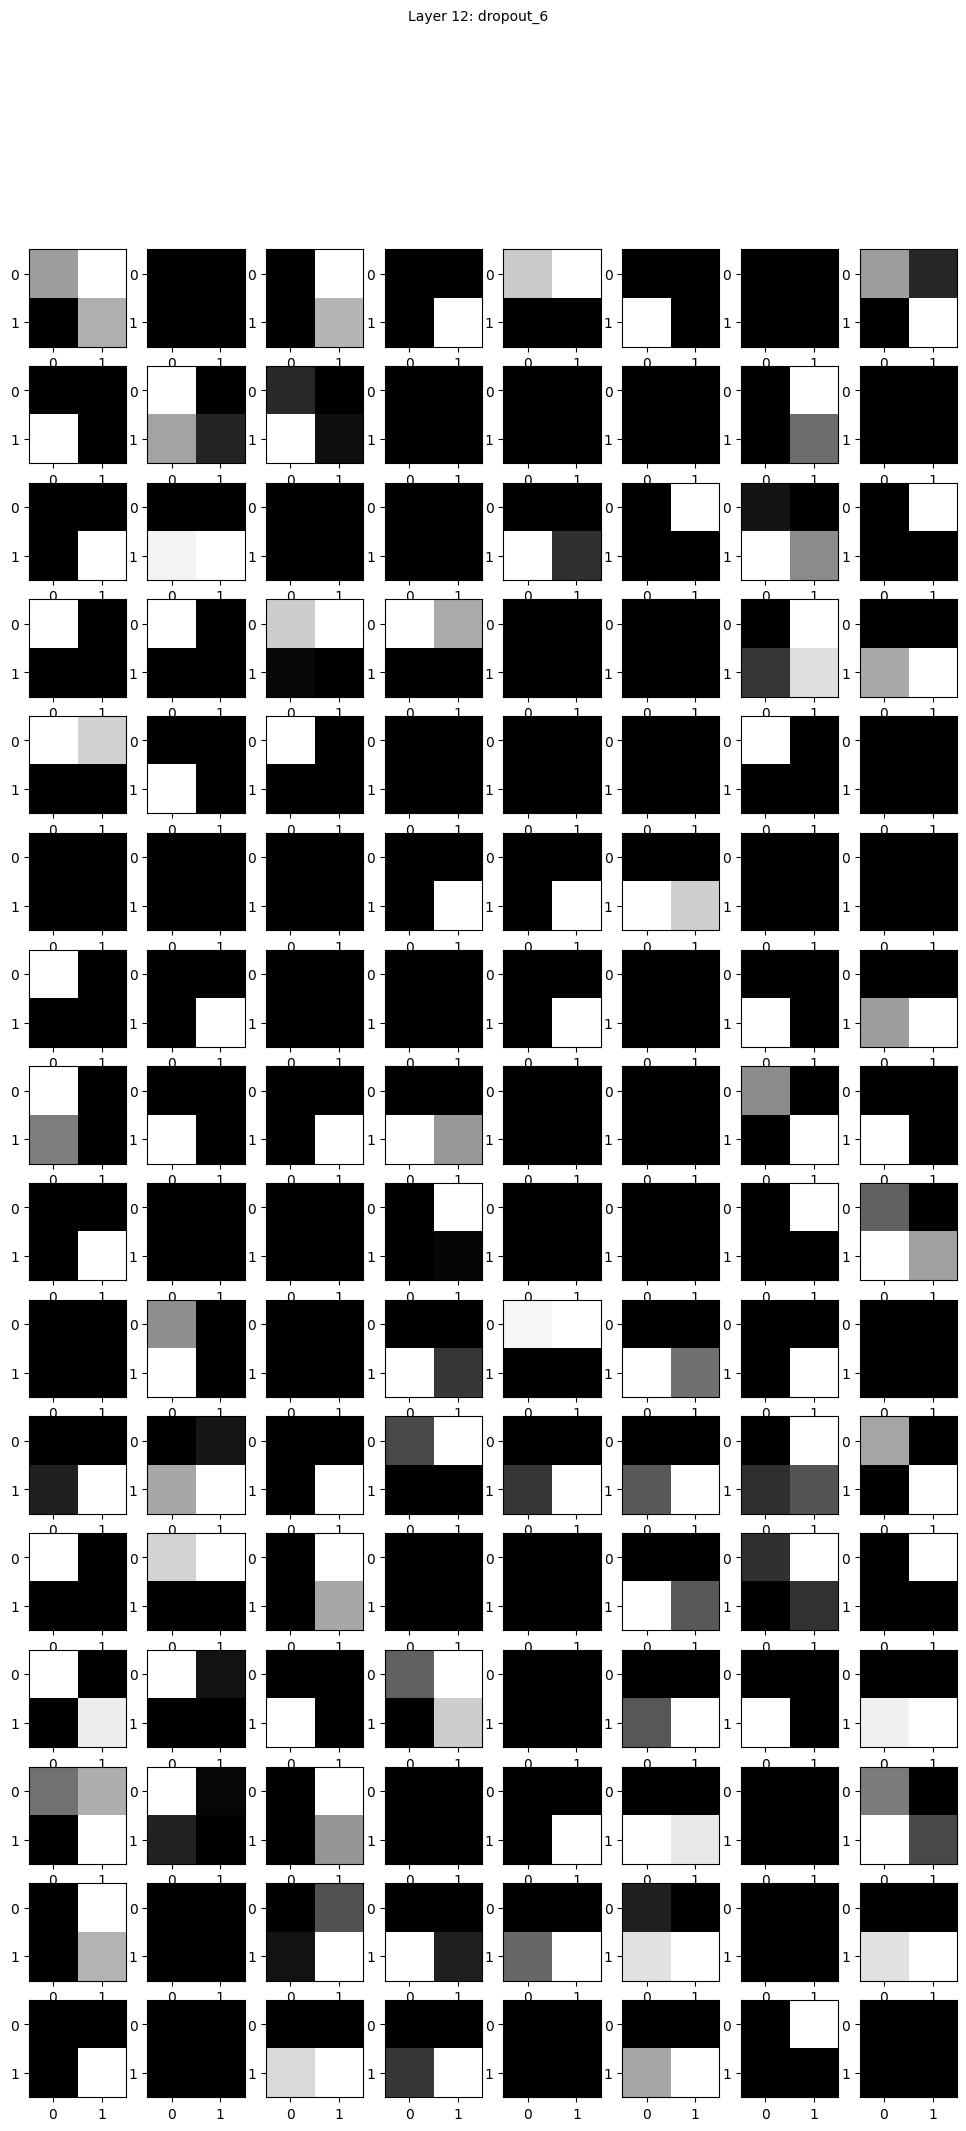

In [11]:
model5by5 = train_model_scheduler_early_callback('model5x5',filter_size=5)

### Model with different learning rates 

/Users/elifozkan/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_55 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_73          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_73 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_74          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_74 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_75          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_75 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_18 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_76          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_76 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,295 (4.38 MB)

 Trainable params: 1,146,823 (4.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

None
Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 69ms/step - accuracy: 0.1497 - loss: 3.1847 - precision_18: 0.1518 - recall_18: 0.0885 - val_accuracy: 0.2424 - val_loss: 2.1646 - val_precision_18: 0.2906 - val_recall_18: 0.0493
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.1688 - loss: 3.0064 - precision_18: 0.1762 - recall_18: 0.0993 - val_accuracy: 0.2655 - val_loss: 1.9217 - val_precision_18: 0.3627 - val_recall_18: 0.0390
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.1833 - loss: 2.8736 - precision_18: 0.1945 - recall_18: 0.1060 - val_accuracy: 0.2875 - val_loss: 1.8745 - val_precision_18: 0.4056 - val_recall_18: 0.0485
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.1892 - loss: 2.7794 - precision_18: 0.2008 - recall_18: 0.1088 - val_accuracy: 0.3009 - val_loss: 1.8533 - val_precision_18: 0.4507 - val_recall_18: 0.0674
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.1945 - loss: 2.7392 - precision

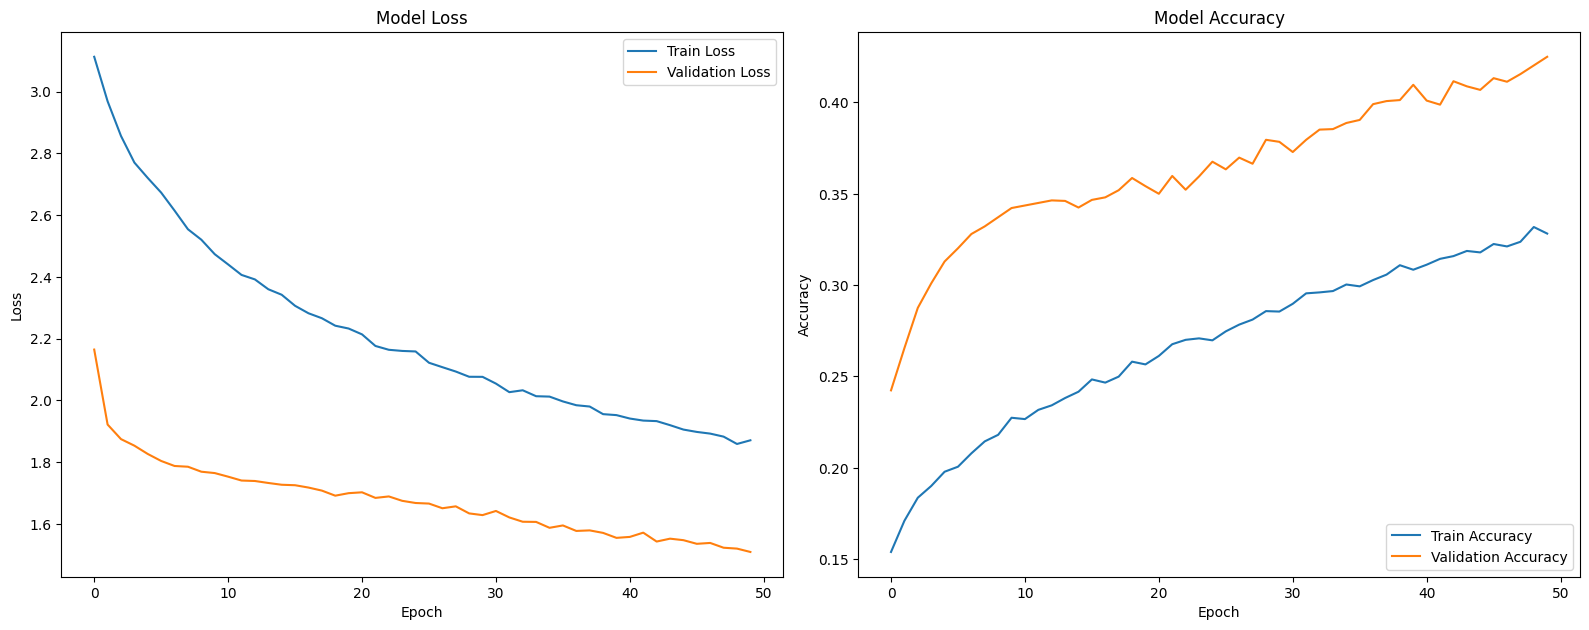

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.4231 - loss: 1.4857 - precision_18: 0.6296 - recall_18: 0.2394
Test Accuracy: 0.42407354712486267
Test Precision: 0.6336780190467834
Test Recall: 0.2390637993812561
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


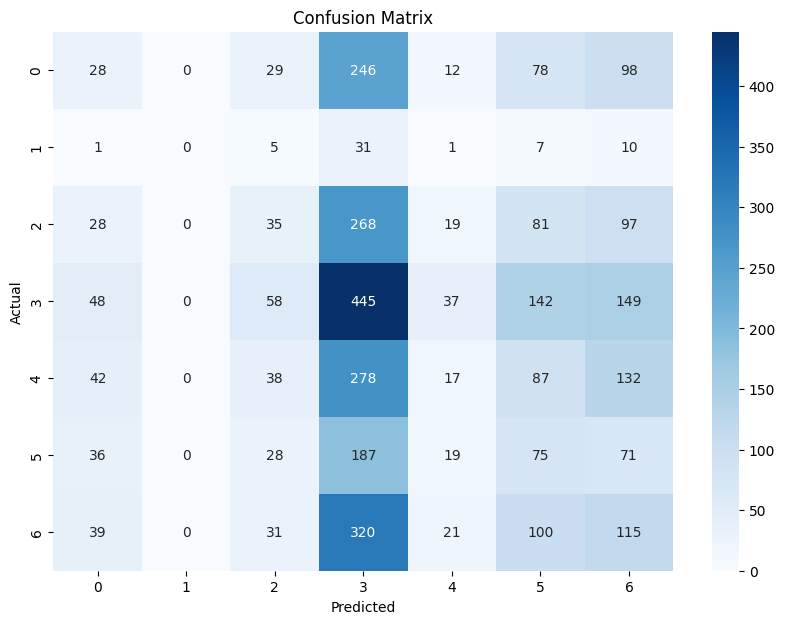

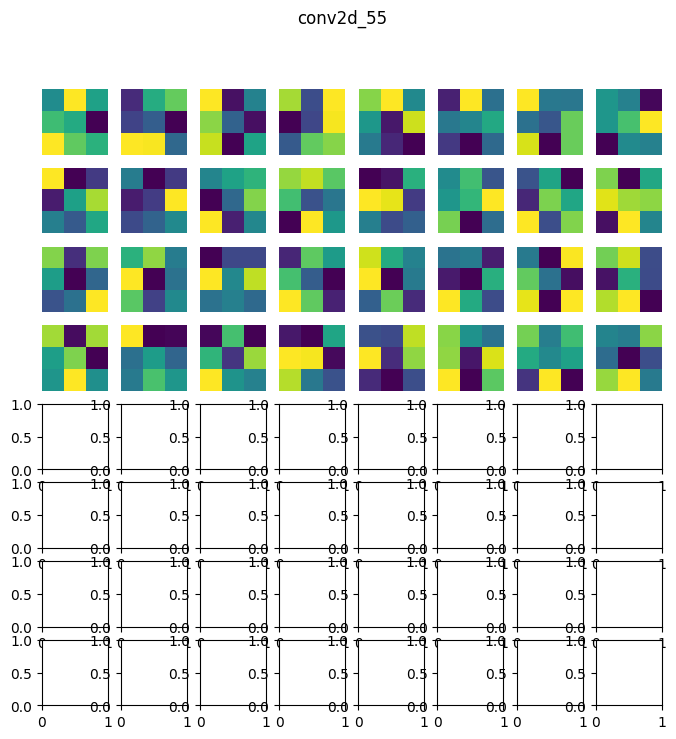

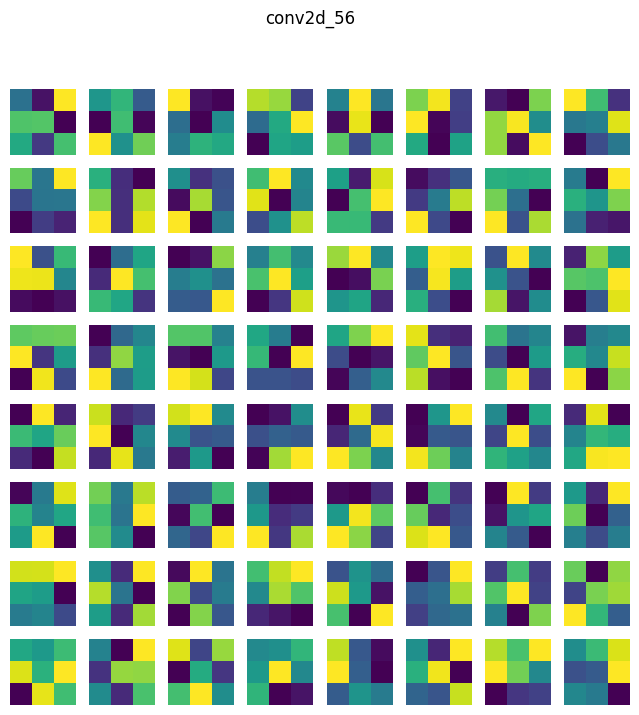

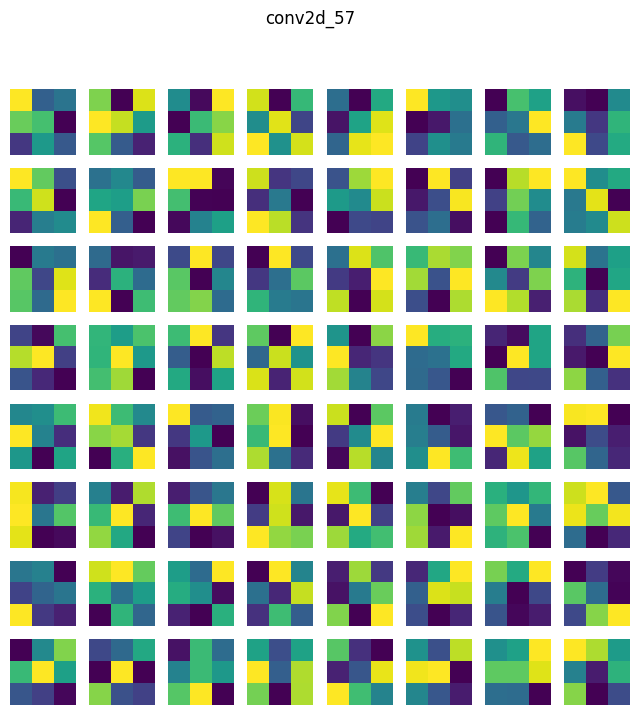

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


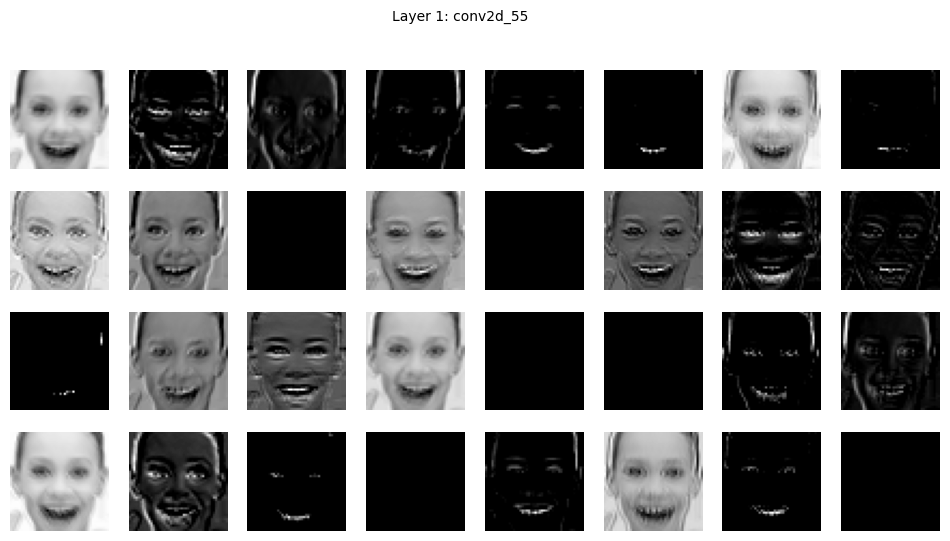

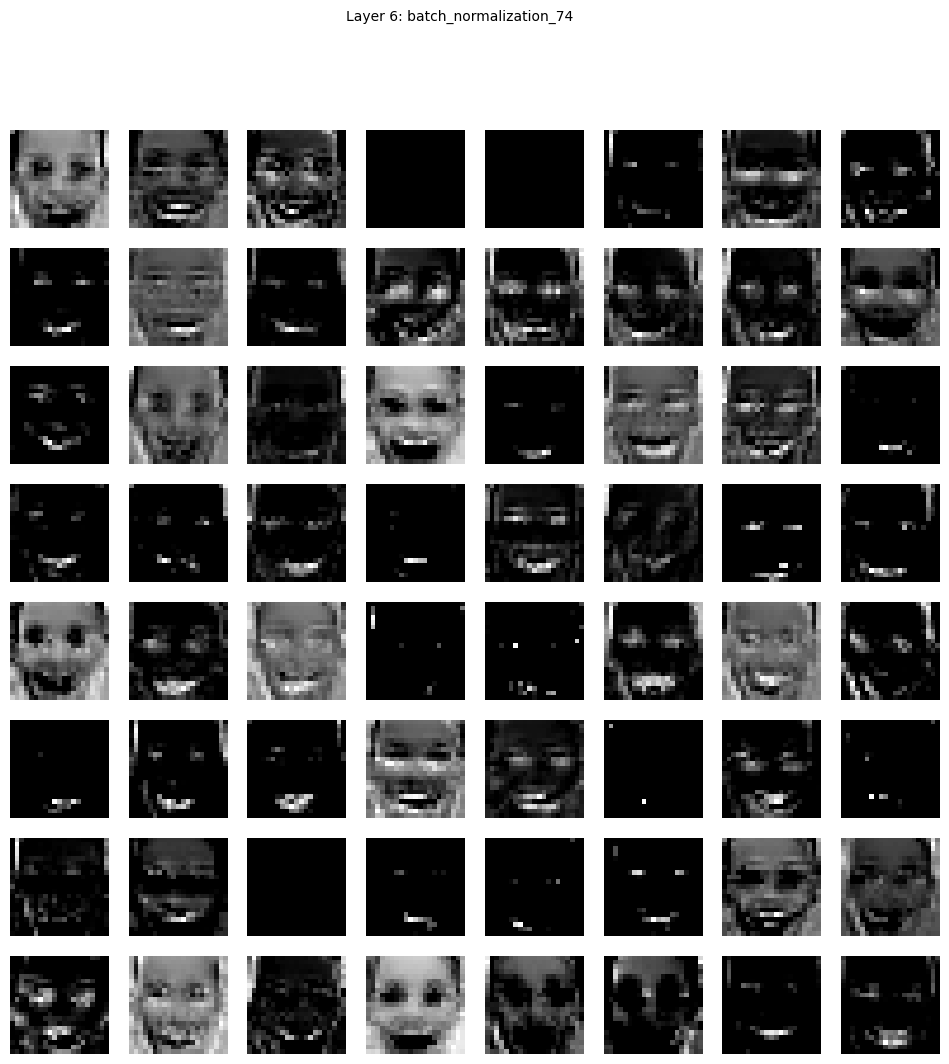

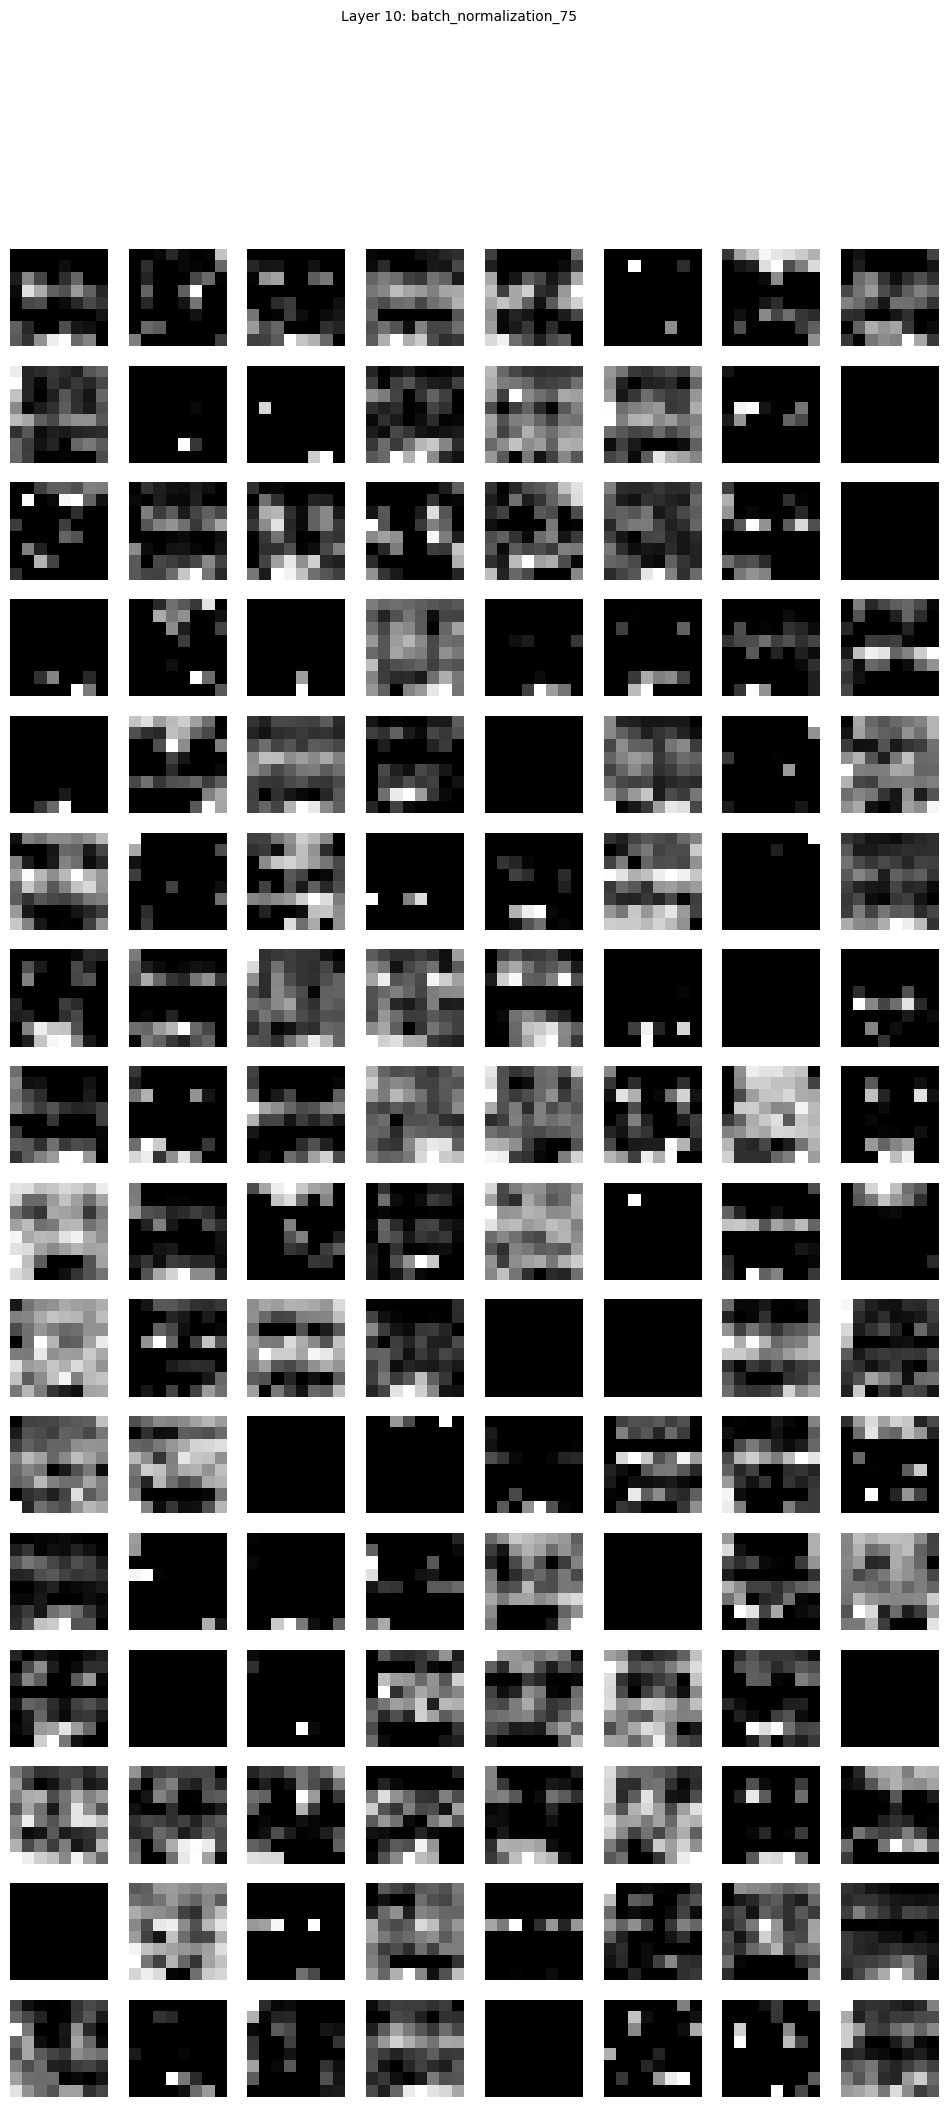

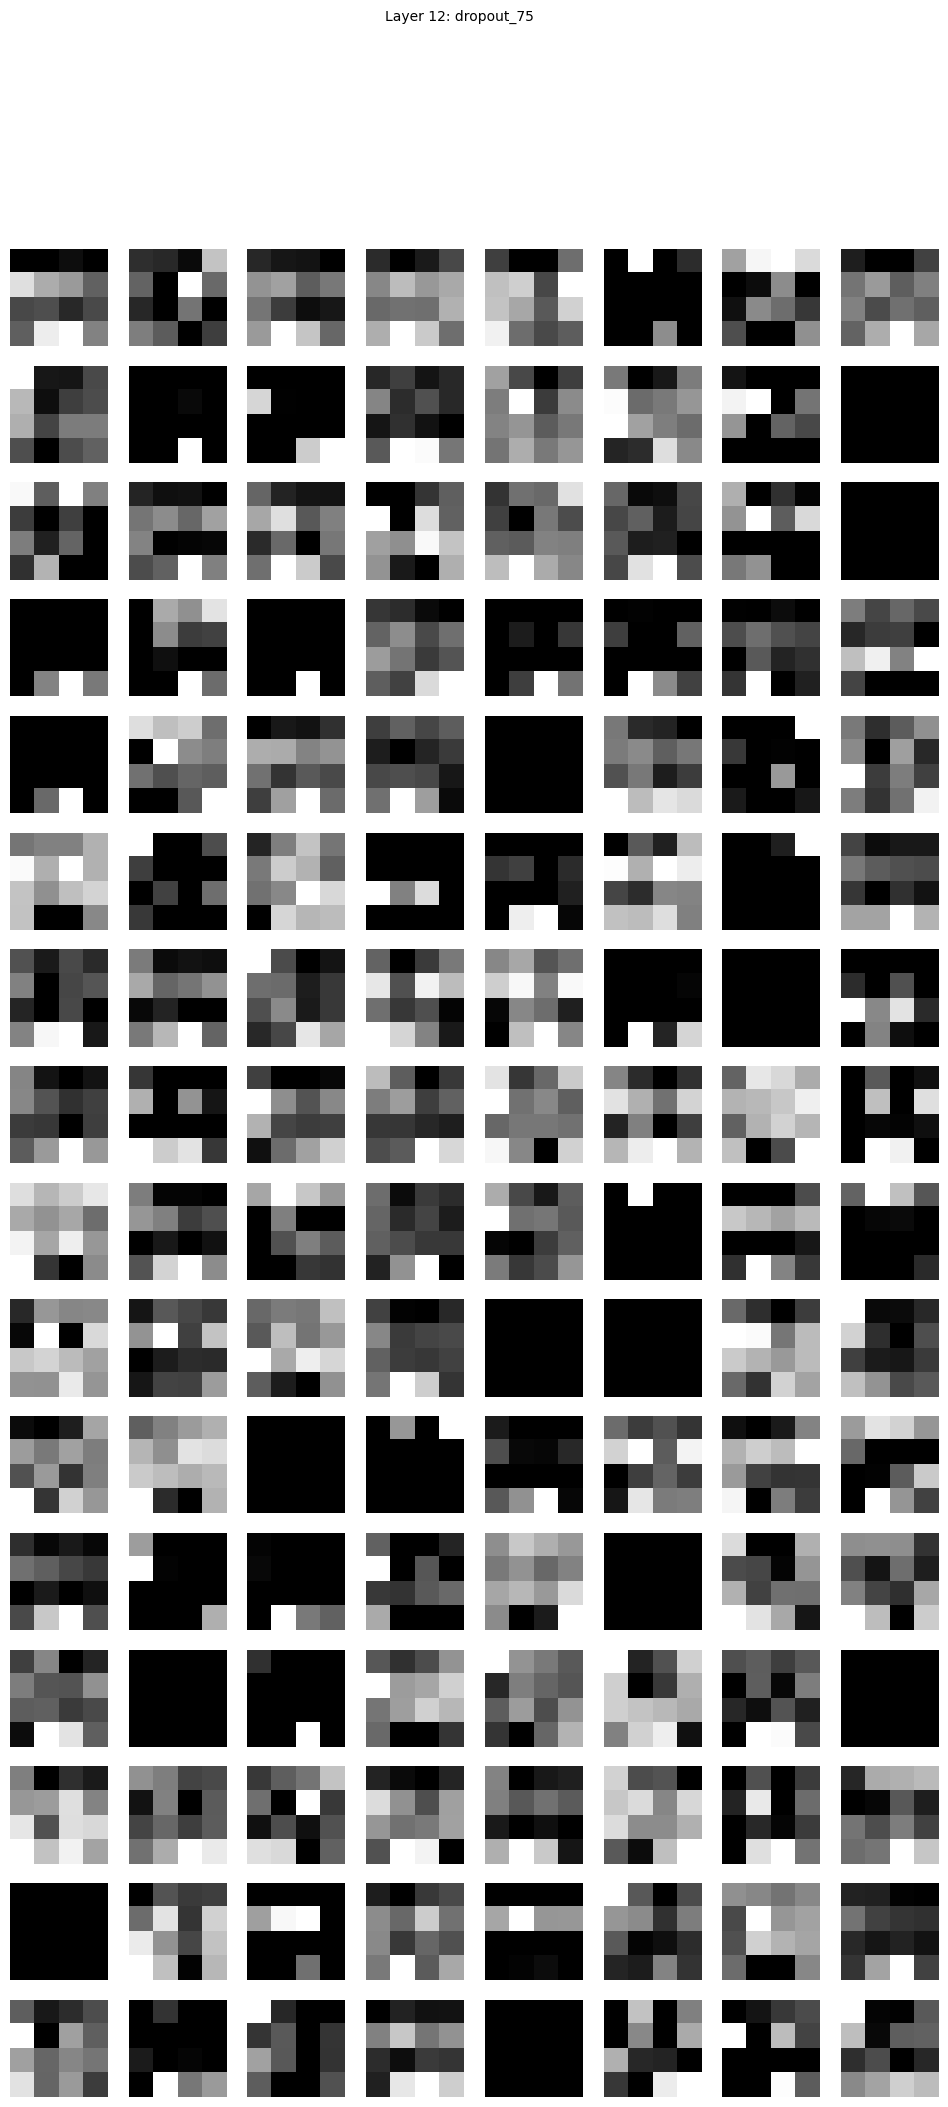

/Users/elifozkan/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_58 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_77          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_58 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_77 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_59 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_78          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_59 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_78 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_60 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_79          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_60 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_79 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_80          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_80 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,295 (4.38 MB)

 Trainable params: 1,146,823 (4.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

None
Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 33s 70ms/step - accuracy: 0.1876 - loss: 3.9968 - precision_19: 0.1935 - recall_19: 0.0902 - val_accuracy: 0.1769 - val_loss: 4.0248 - val_precision_19: 0.1798 - val_recall_19: 0.1491
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.2015 - loss: 2.1431 - precision_19: 0.2098 - recall_19: 0.0457 - val_accuracy: 0.2009 - val_loss: 2.0182 - val_precision_19: 0.0000e+00 - val_recall_19: 0.0000e+00
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.1965 - loss: 2.2851 - precision_19: 0.2093 - recall_19: 0.0719 - val_accuracy: 0.2491 - val_loss: 2.1992 - val_precision_19: 0.2883 - val_recall_19: 0.0666
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 69ms/step - accuracy: 0.2109 - loss: 2.3068 - precision_19: 0.2318 - recall_19: 0.0925 - val_accuracy: 0.1800 - val_loss: 7188.6382 - val_precision_19: 0.1837 - val_recall_19: 0.1421
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 70ms/step - accuracy: 0.2007 - loss: 2.4086 

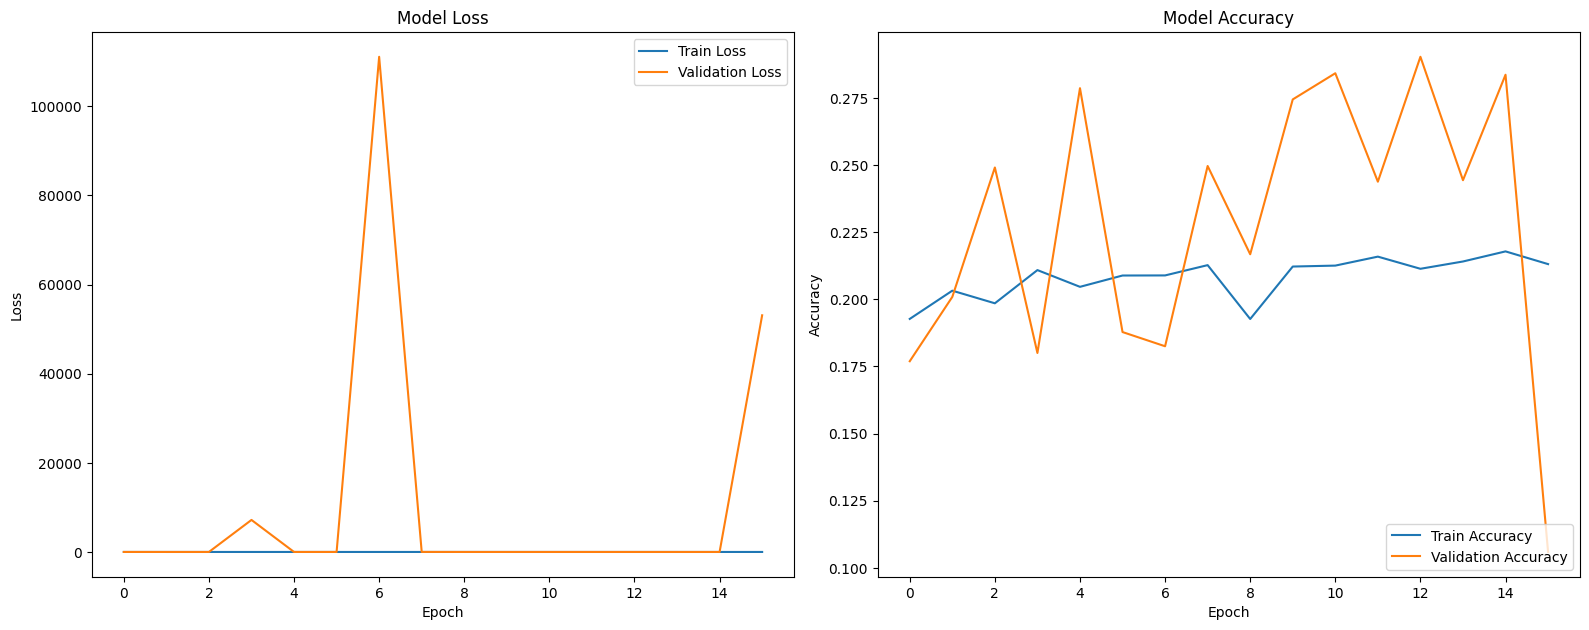

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2721 - loss: 1.8713 - precision_19: 0.3992 - recall_19: 0.0520
Test Accuracy: 0.2764001190662384
Test Precision: 0.3951434791088104
Test Recall: 0.04987461864948273
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


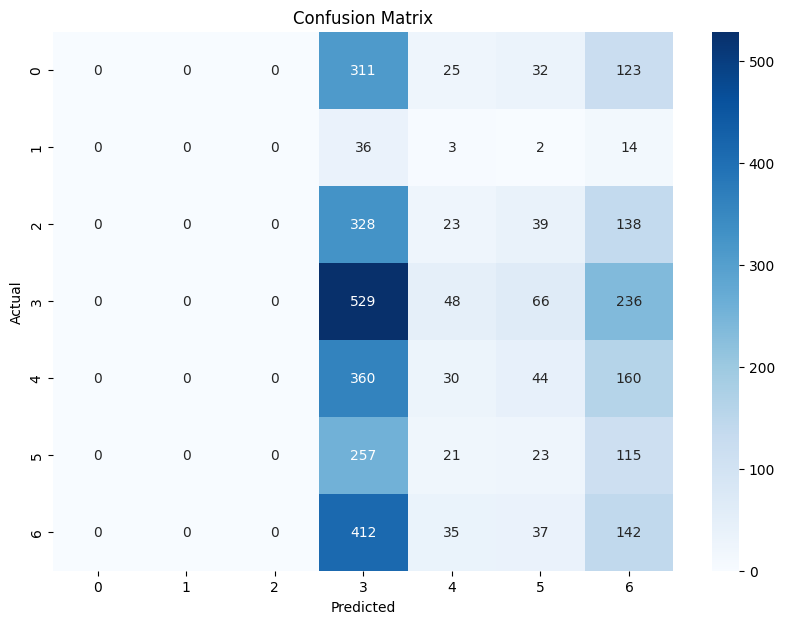

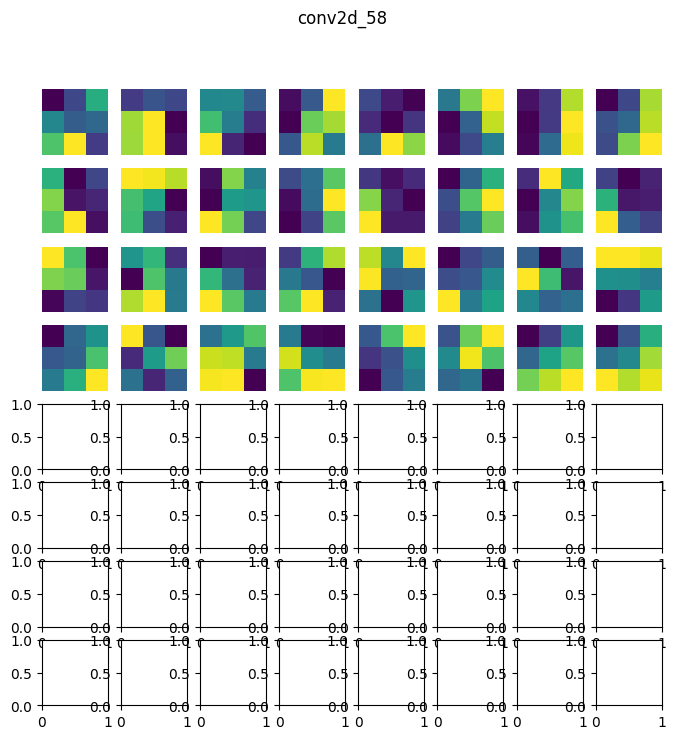

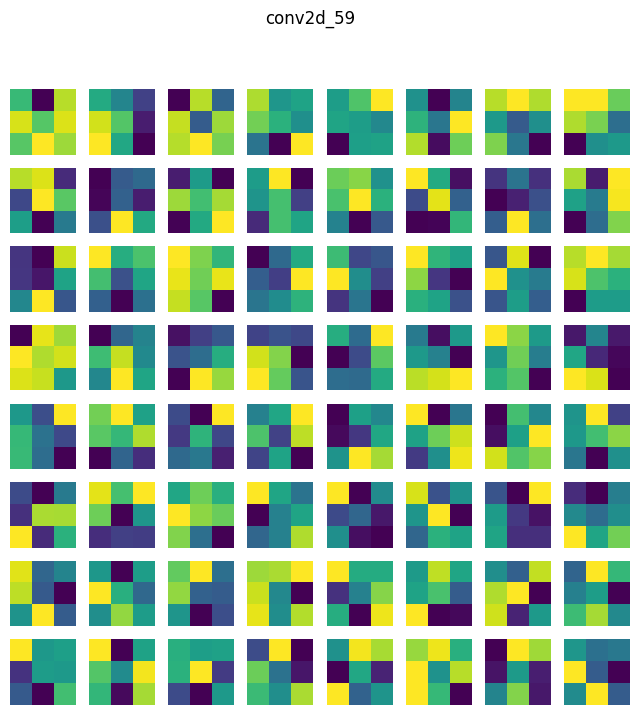

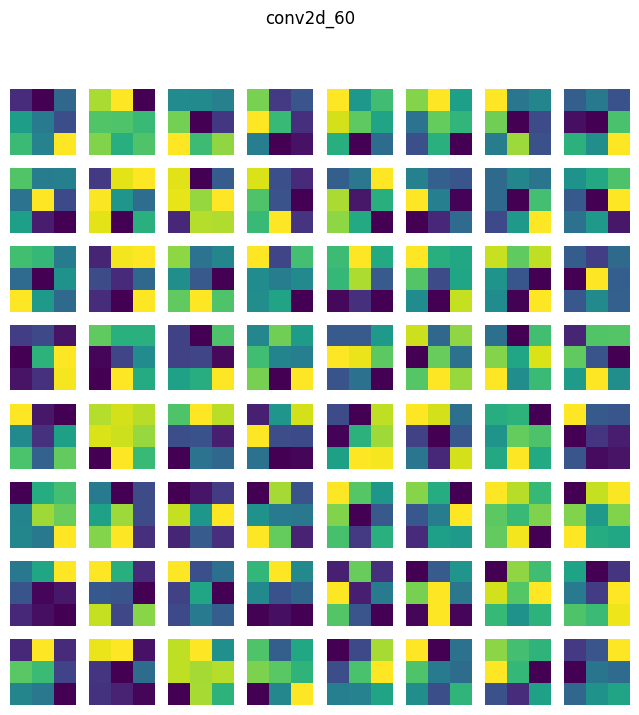

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


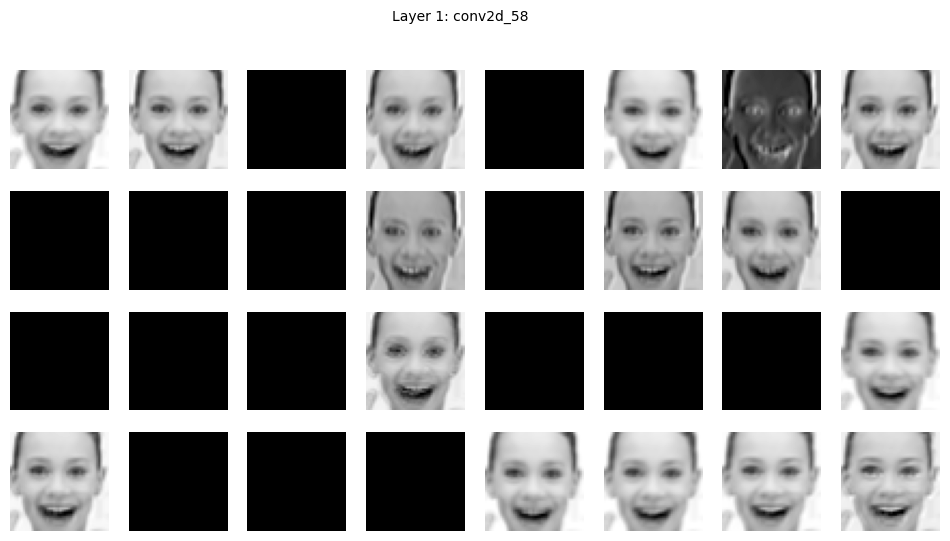

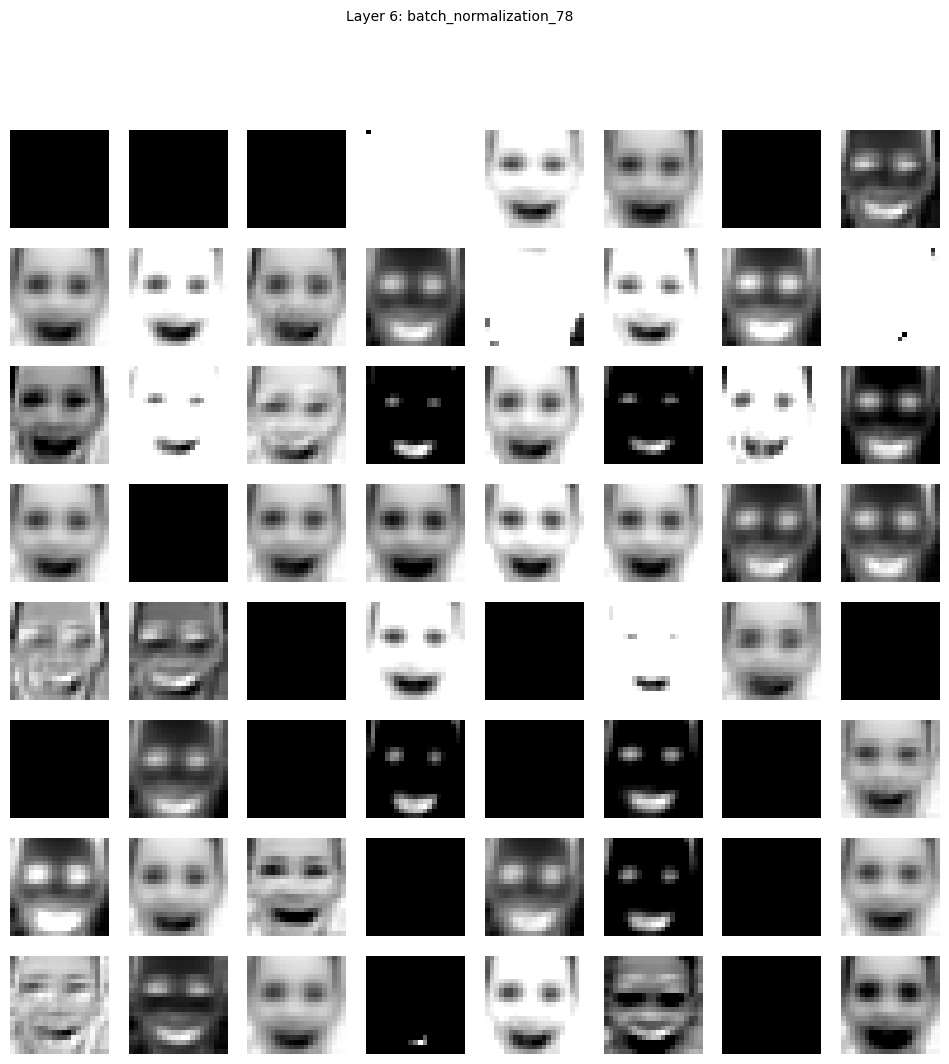

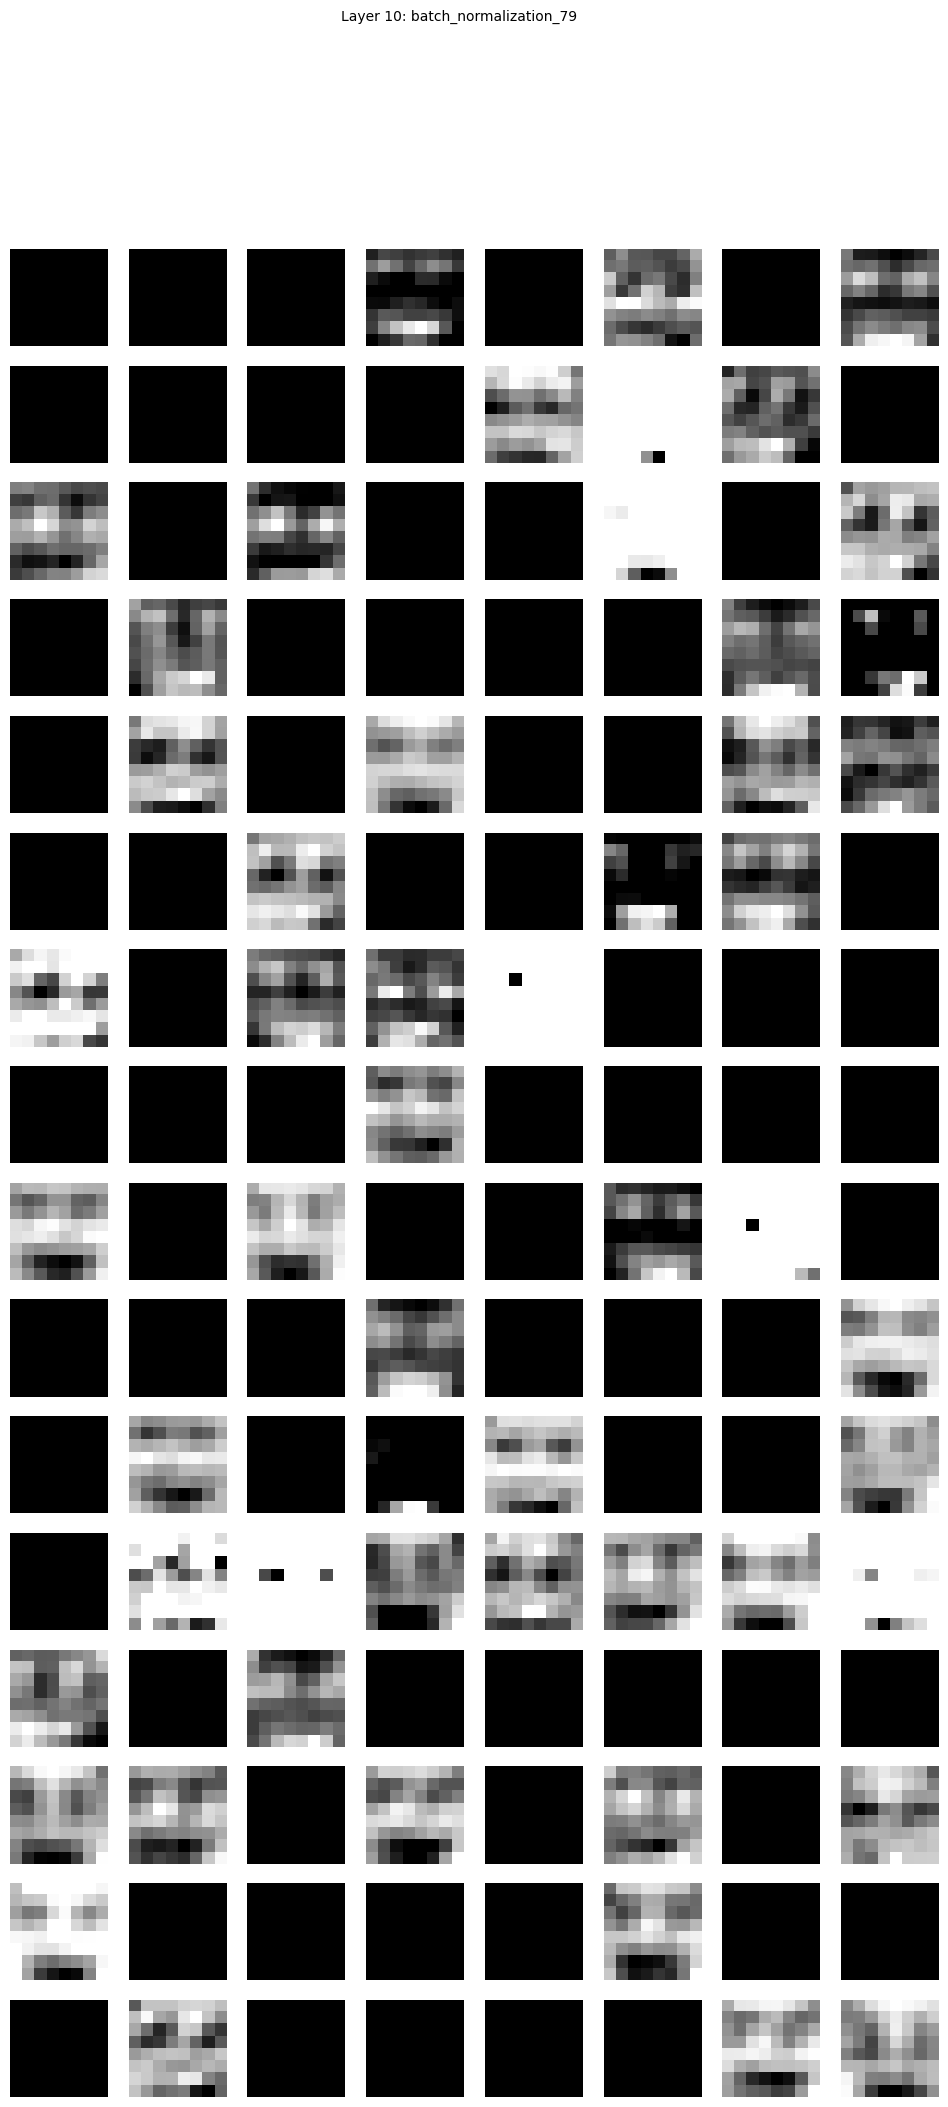

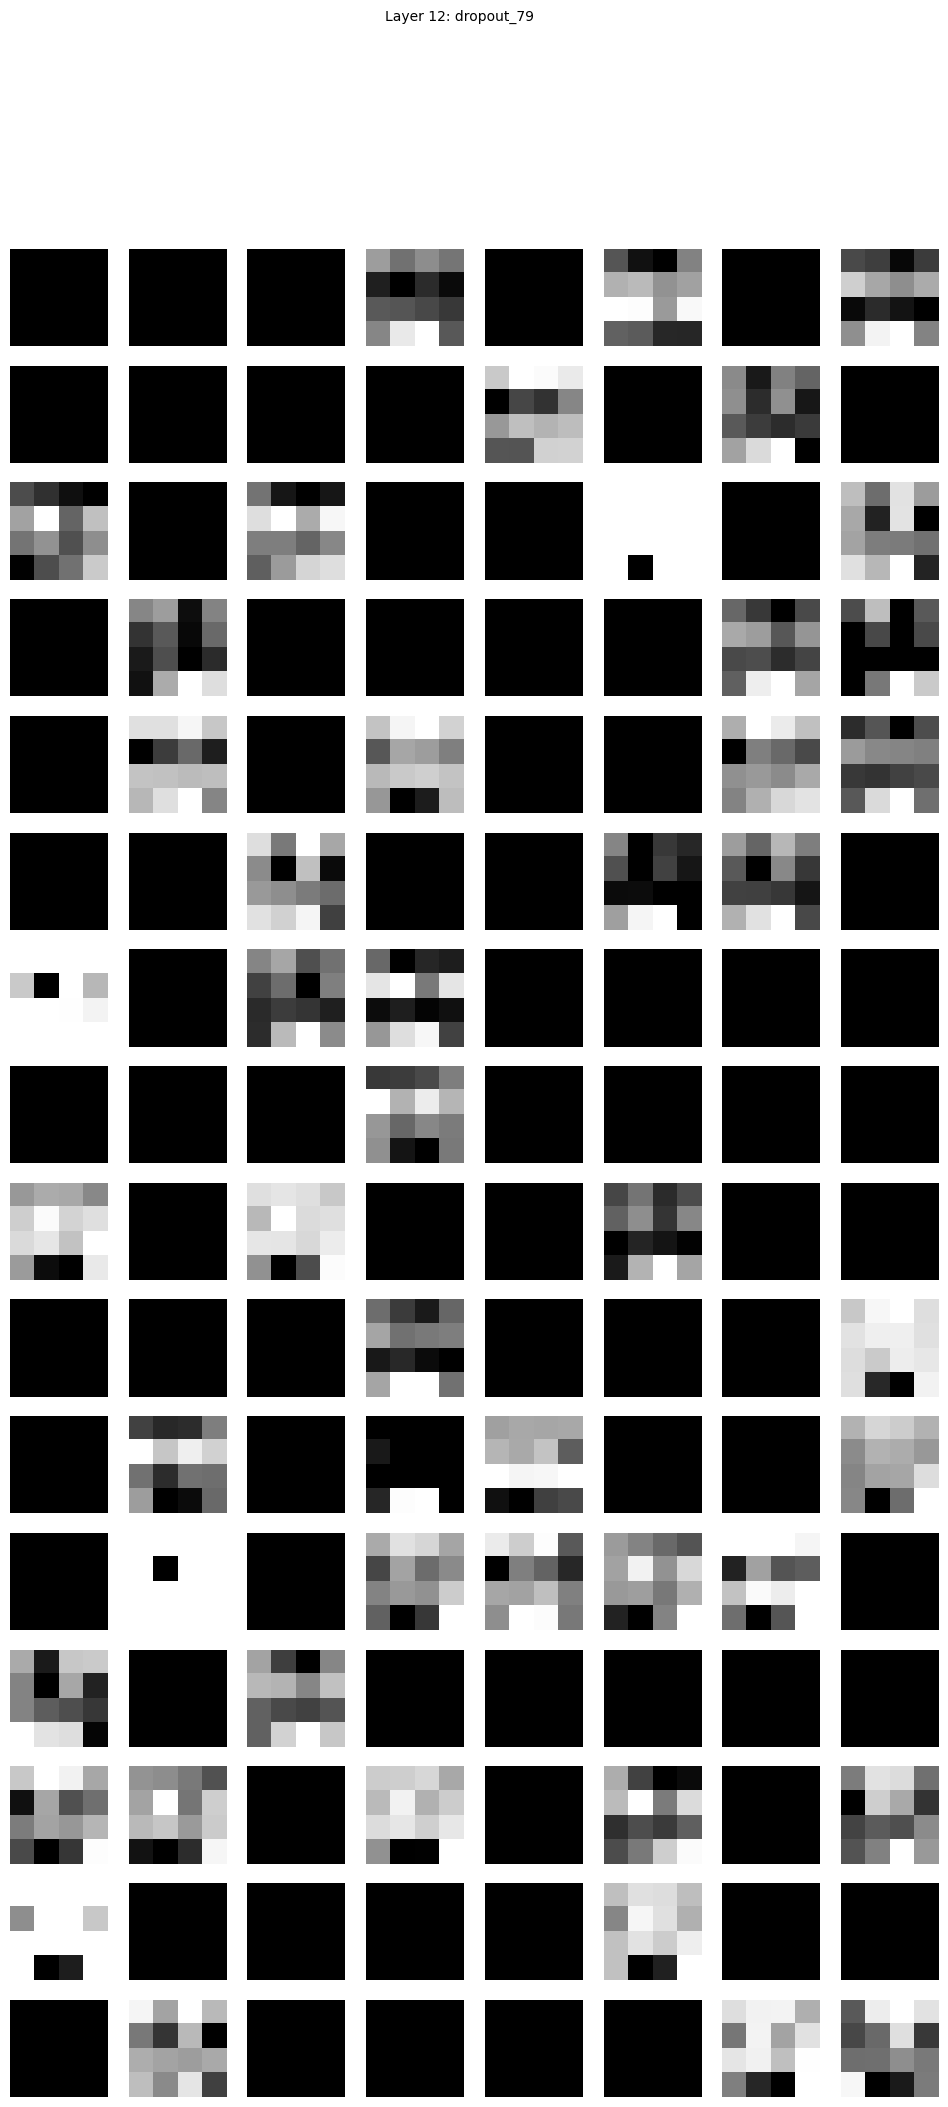

/Users/elifozkan/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_61 (Conv2D)              │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_81          │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_61 (MaxPooling2D) │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_81 (Dropout)            │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_62 (Conv2D)              │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_82          │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_62 (MaxPooling2D) │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_82 (Dropout)            │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_63 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_63 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_83 (Dropout)            │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_20 (Flatten)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_84 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,295 (4.38 MB)

 Trainable params: 1,146,823 (4.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

None
Epoch 1/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.2108 - loss: 2.9788 - precision_20: 0.2157 - recall_20: 0.0743 - val_accuracy: 0.1953 - val_loss: 1.9304 - val_precision_20: 0.2083 - val_recall_20: 0.0084
Epoch 2/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.2352 - loss: 1.8765 - precision_20: 0.2853 - recall_20: 0.0189 - val_accuracy: 0.2399 - val_loss: 1.8383 - val_precision_20: 0.2909 - val_recall_20: 0.0471
Epoch 3/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.2442 - loss: 1.9053 - precision_20: 0.3139 - recall_20: 0.0465 - val_accuracy: 0.2421 - val_loss: 1.9615 - val_precision_20: 0.2933 - val_recall_20: 0.0245
Epoch 4/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 30s 67ms/step - accuracy: 0.2764 - loss: 1.8777 - precision_20: 0.4040 - recall_20: 0.0909 - val_accuracy: 0.3279 - val_loss: 1.6829 - val_precision_20: 0.7077 - val_recall_20: 0.0256
Epoch 5/50
449/449 ━━━━━━━━━━━━━━━━━━━━ 31s 68ms/step - accuracy: 0.2970 - loss: 1.8487 - precision

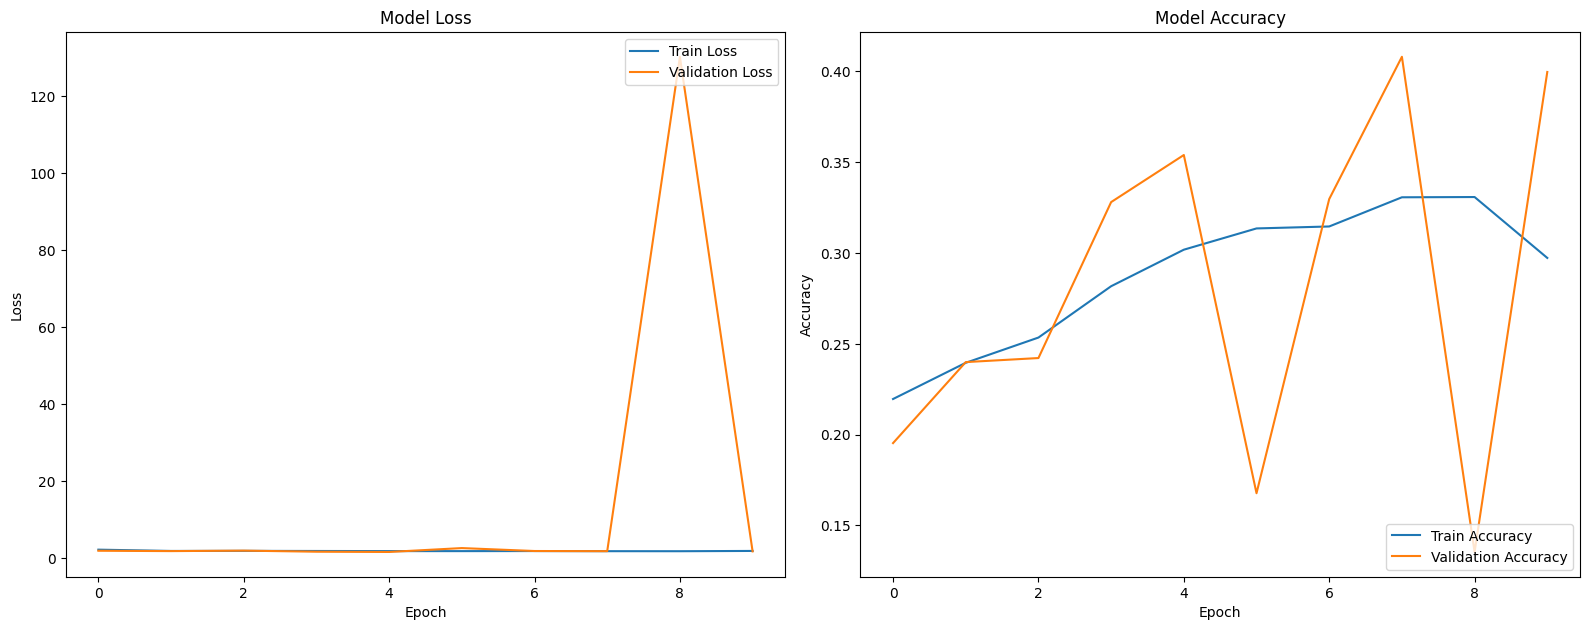

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3637 - loss: 1.5867 - precision_20: 0.6019 - recall_20: 0.1507
Test Accuracy: 0.36138200759887695
Test Precision: 0.6037934422492981
Test Recall: 0.15965449810028076
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


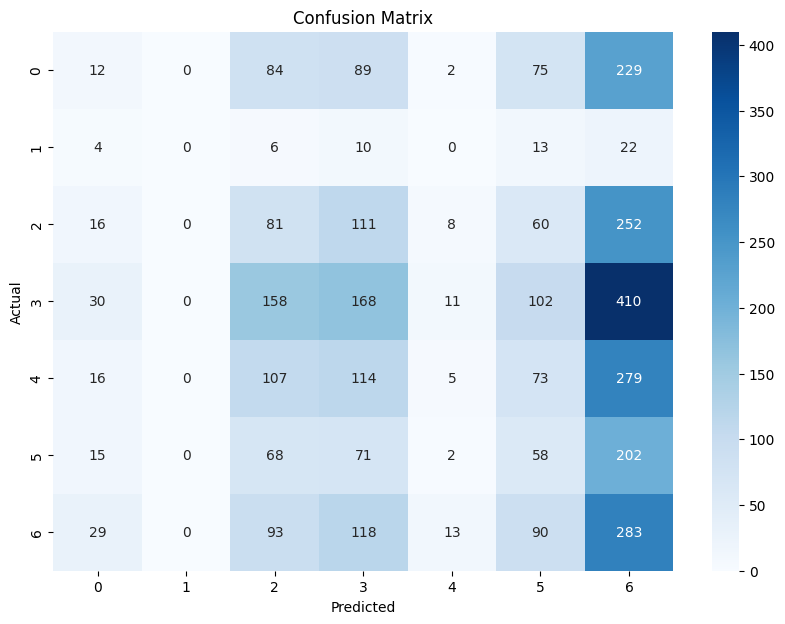

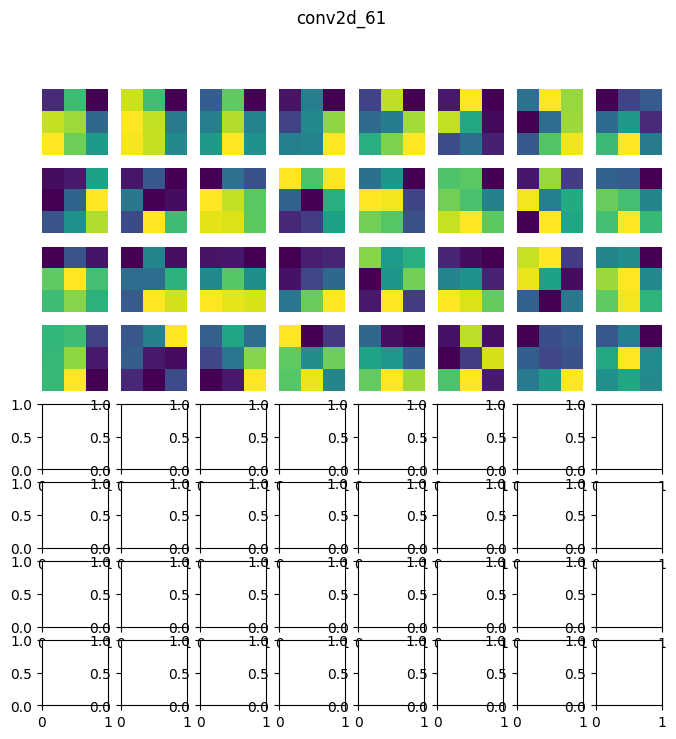

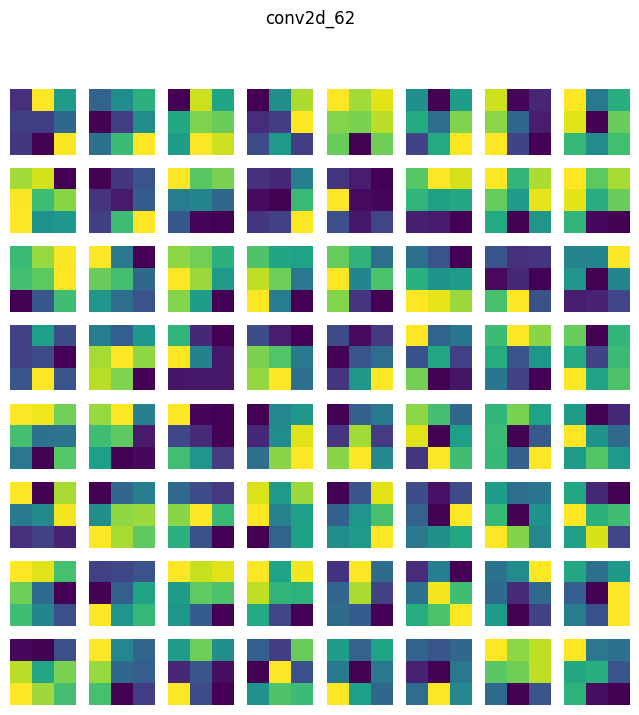

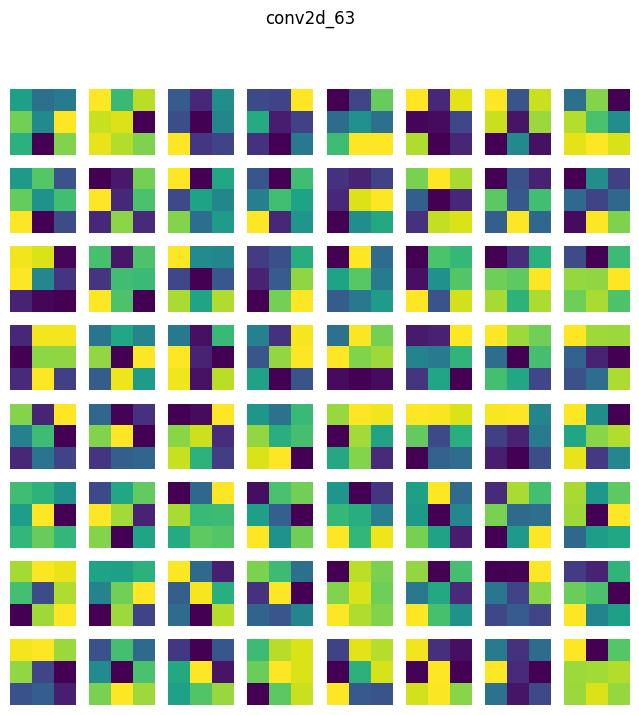

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step


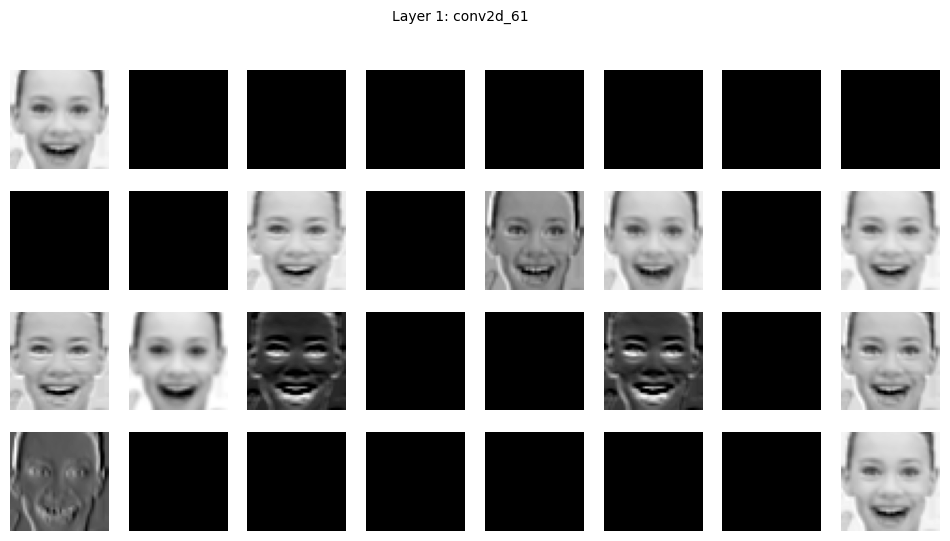

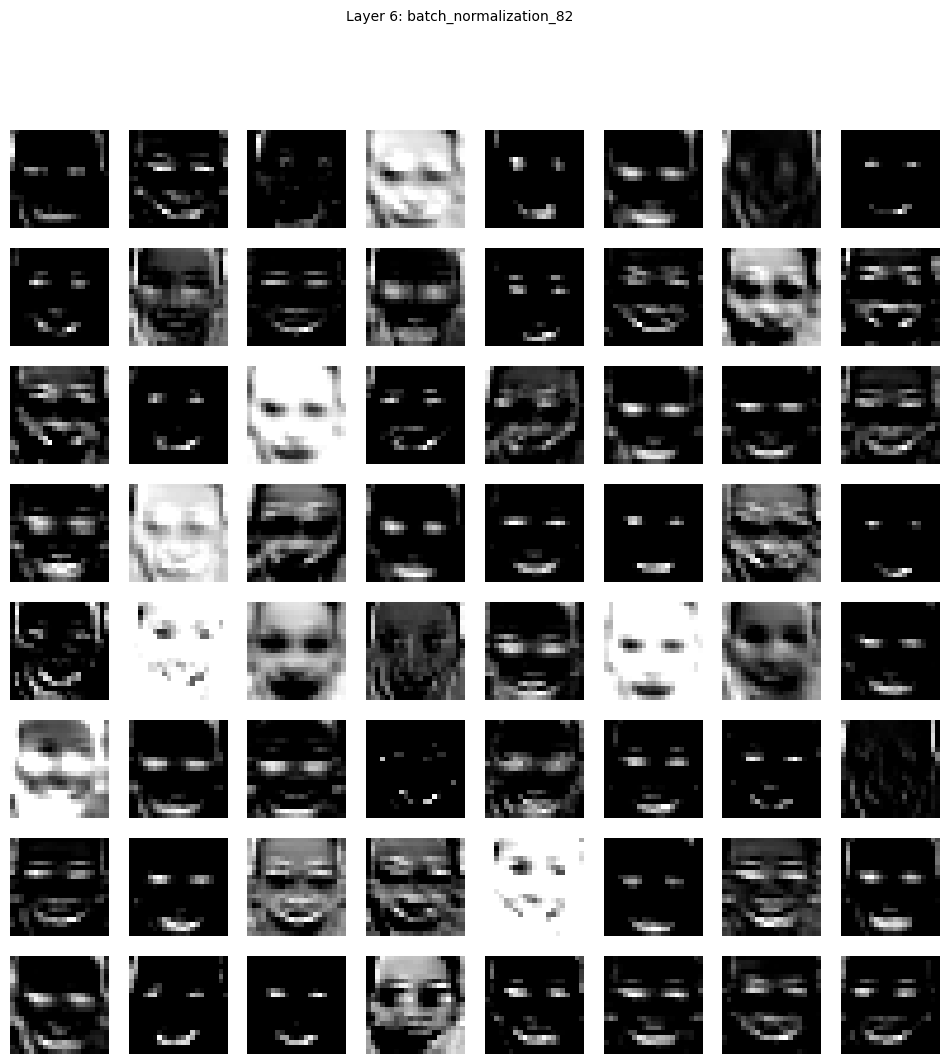

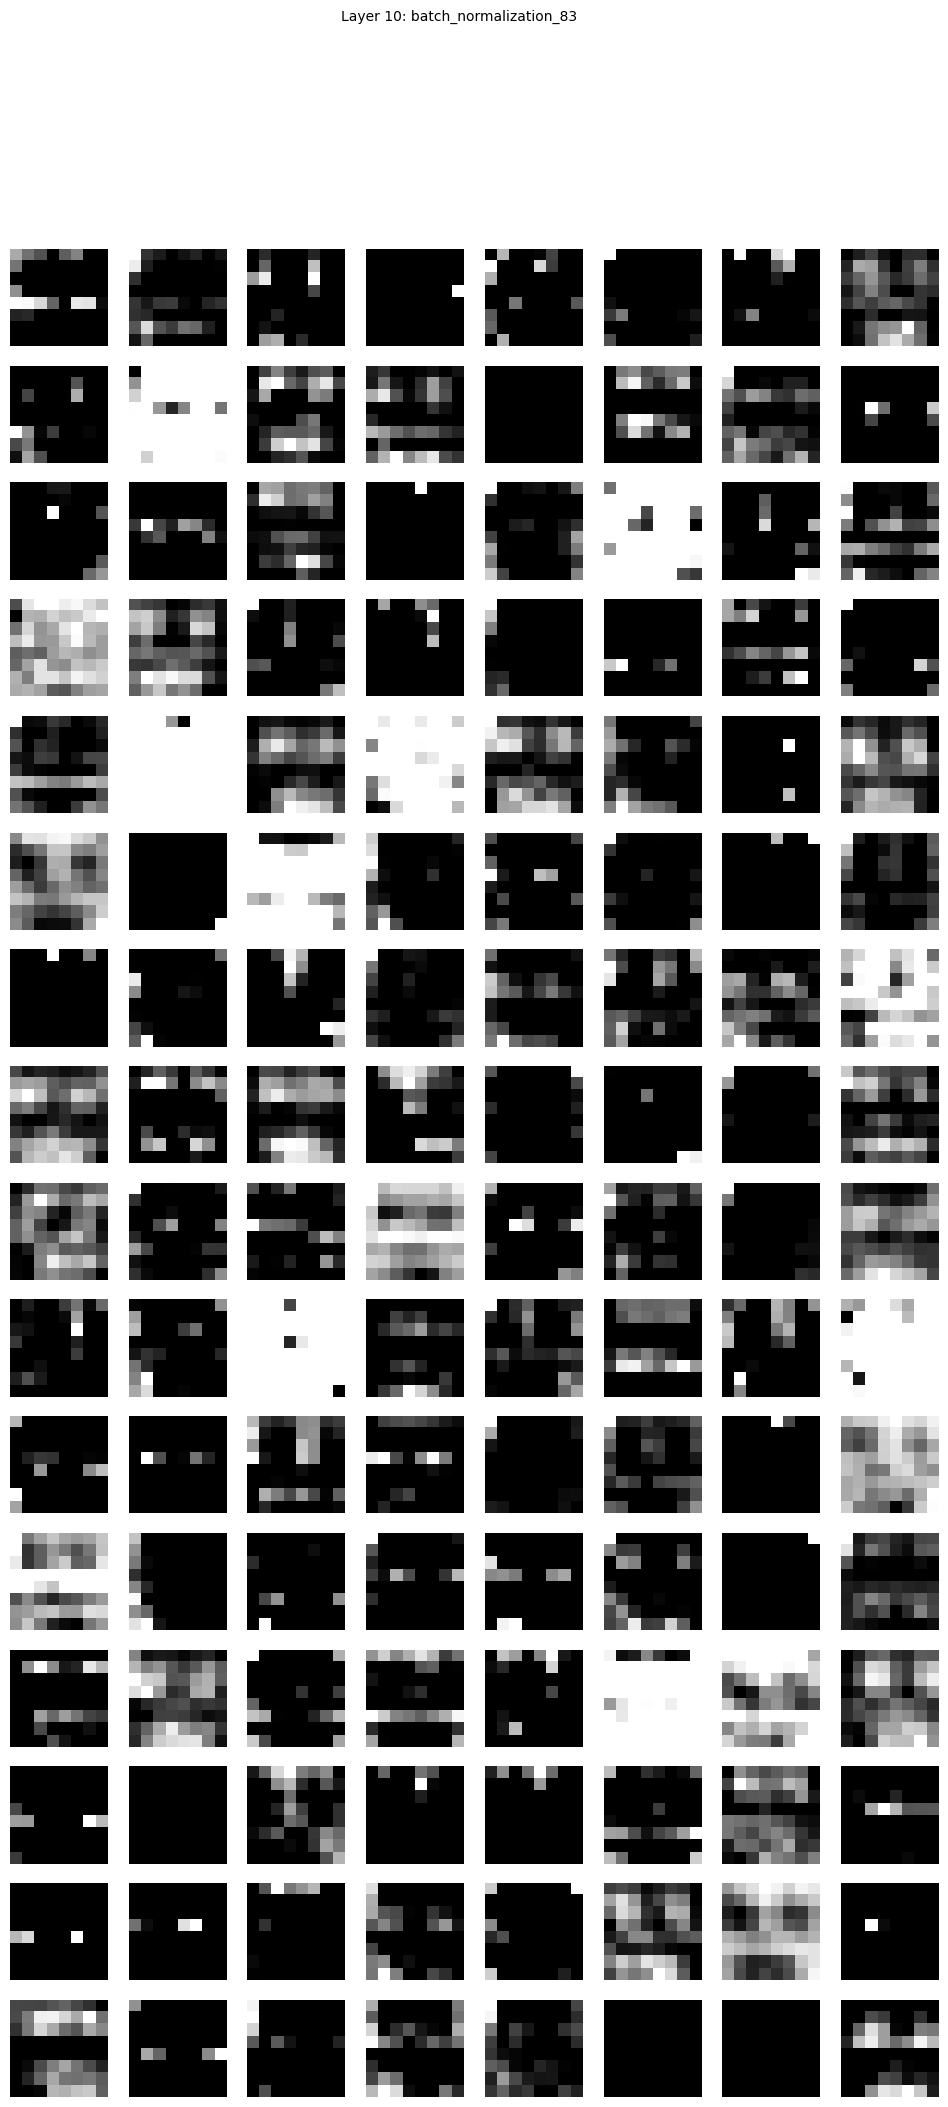

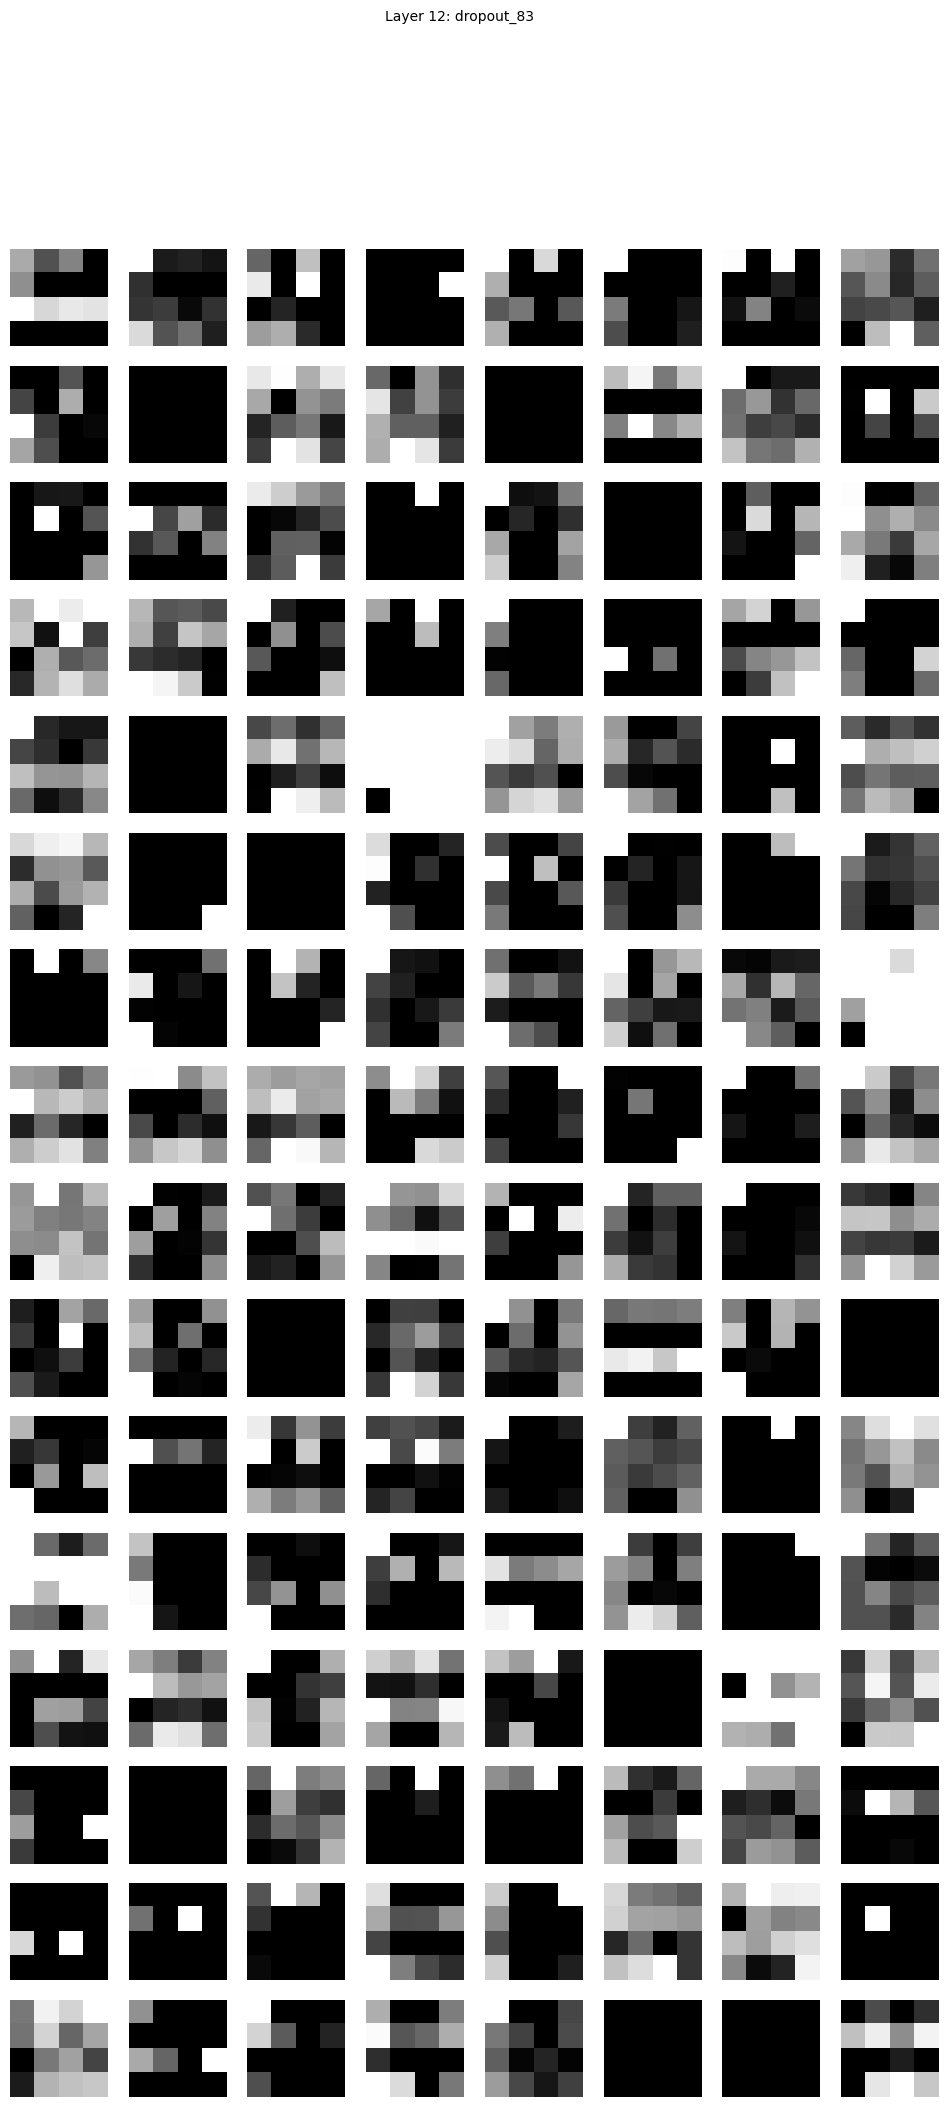

In [74]:
learning_rates = [0.00001, 0.1, 0.05]
for learning_rate in learning_rates: 
    model = train_model_scheduler_early_callback(f'model_learning_rate{learning_rate}',learning_rate=learning_rate)

In [1]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array

model = tf.keras.models.load_model('/Users/elifozkan/Desktop/CV-Assignment2/model128.keras')
emotion_label_to_text = {0: 'anger', 1: 'disgust', 2: 'fear', 3: 'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

camera = cv2.VideoCapture(0)
#Haar Cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def predict_emotion(face):
    face = cv2.resize(face, (48, 48))
    face = face.astype("float") / 255.0
    face = img_to_array(face)
    face = np.expand_dims(face, axis=0)
    predictions = model.predict(face)[0]
    max_index = np.argmax(predictions)
    return emotion_label_to_text[max_index], predictions[max_index]

#got help from LLMs at this point 
while True:
    ret, frame = camera.read()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # detect faces in the frame
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        #w and h returns the bounding box, x and y the poisiton of the bounding box 
        face = gray[y:y + h, x:x + w] #we only get the area which is bounded by the fae detection
        emotion, confidence = predict_emotion(face) #predict the emotion
        # draw rectangle around the face and add the emotion label
        cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 2)
        cv2.putText(frame, f'{emotion}: {confidence:.2f}', (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2)
    
    cv2.imshow('Emotion Recognition', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

camera.release()
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━

: 